In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import os
from pathlib import Path
try:
    import holidays
except ImportError:
    print("Warning: holidays package not found. Install with: pip install holidays")
    holidays = None
from scipy import stats as scipy_stats
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")


Libraries imported successfully!


---

## Control Region Load Data Analysis

Analyze temporal coverage of control region-based load data to determine availability throughout the dataset period.


CONTROL REGION LOAD DATA TEMPORAL COVERAGE ANALYSIS

Loading dataset: ../opsd-time_series-2020-10-06/time_series_60min_singleindex.csv

Dataset loaded:
Shape: 50,401 rows × 299 columns
Date range: 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00

Control Regions (5): ['DE_50hertz', 'DE_amprion', 'DE_tennet', 'DE_transnetbw', 'DE_LU']
4 TSOs (50hertz, amprion, tennet, transnetbw): Full coverage from 2015
DE_LU (bidding zone + control region): Starts Oct 2018 (creates temporal imbalance)
Comparison columns: ['DE']

TEMPORAL COVERAGE ANALYSIS

RESULTS SUMMARY

DE_load_actual_entsoe_transparency:
Total Coverage: 100.00%
First Non-Null Date: 2015-01-01 00:00:00+00:00
Last Non-Null Date: 2020-09-30 23:00:00+00:00
Non-Null Values: 50,400 / 50,401
Coverage by Year:
      2015: 100.0% (8,760/8,760)
      2016: 100.0% (8,784/8,784)
      2017: 100.0% (8,760/8,760)
      2018: 100.0% (8,760/8,760)
      2019: 100.0% (8,760/8,760)
      2020: 100.0% (6,576/6,576)

DE_50hertz_load_actual_ents

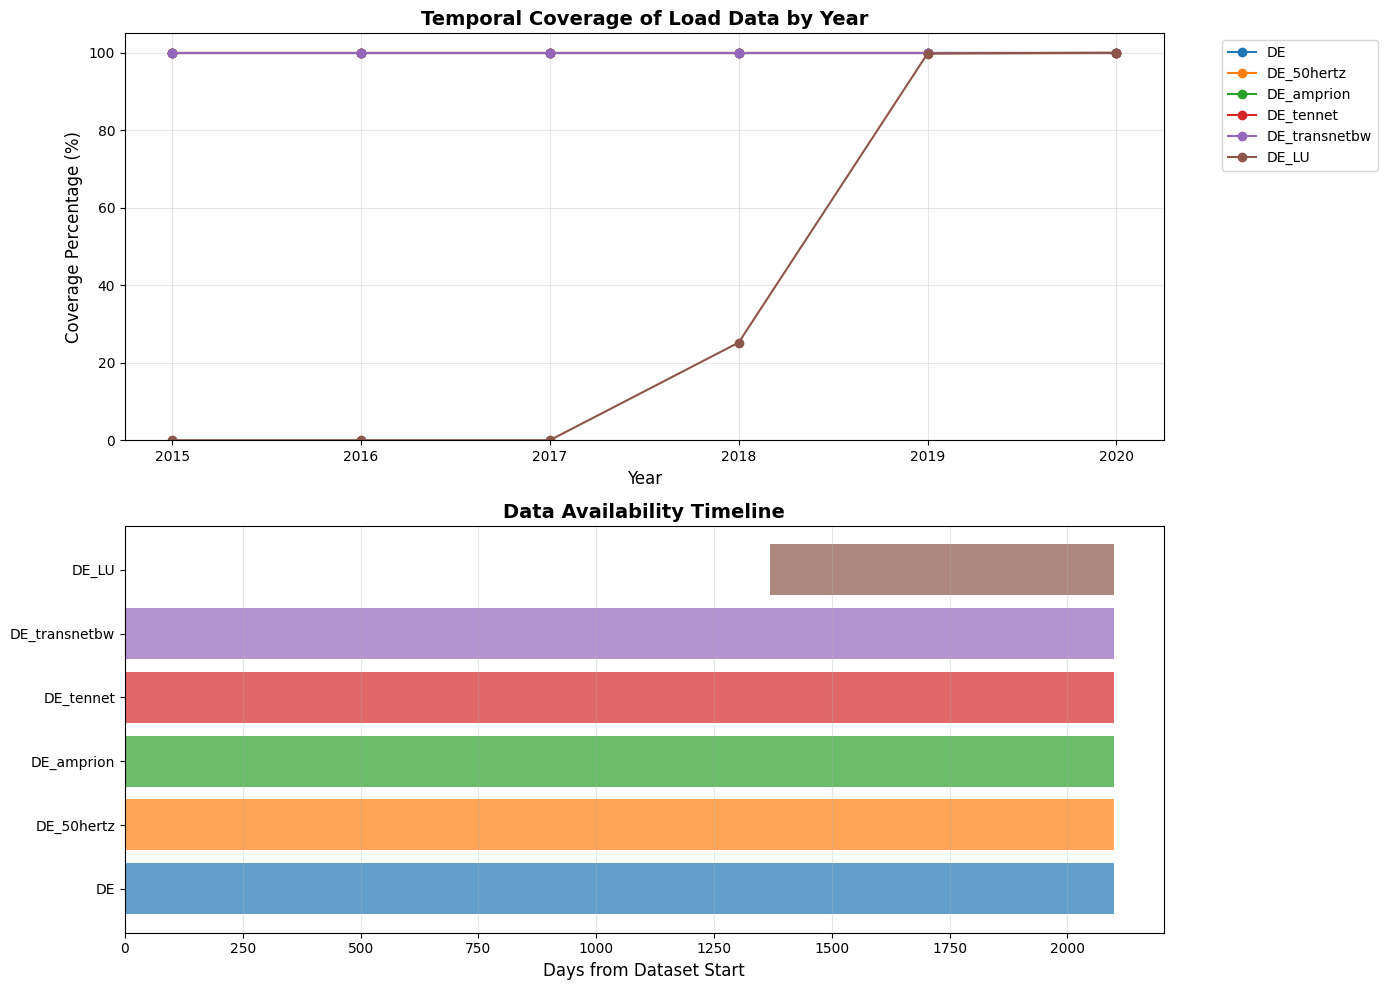


DETAILED COVERAGE TABLE

       Column Total Coverage % First Data   2015   2016   2017   2018   2019   2020
           DE          100.00% 2015-01-01 100.0% 100.0% 100.0% 100.0% 100.0% 100.0%
   DE_50hertz          100.00% 2015-01-01 100.0% 100.0% 100.0% 100.0% 100.0% 100.0%
   DE_amprion          100.00% 2015-01-01 100.0% 100.0% 100.0% 100.0% 100.0% 100.0%
    DE_tennet          100.00% 2015-01-01 100.0% 100.0% 100.0% 100.0% 100.0% 100.0%
DE_transnetbw          100.00% 2015-01-01 100.0% 100.0% 100.0% 100.0% 100.0% 100.0%
        DE_LU           34.77% 2018-10-01   0.0%   0.0%   0.0%  25.2%  99.8% 100.0%

KEY FINDINGS

Control Regions with Data from 2015-2020:
  ✓ DE_50hertz
  ✓ DE_amprion
  ✓ DE_tennet
  ✓ DE_transnetbw

Control Regions with Partial Coverage:
DE_LU (starts: 2018, coverage: 34.77%)

[TEMPORAL IMBALANCE DETECTED] DE_LU (bidding zone + control region) has 34.77% coverage, starts: 2018-10-01
  This temporal imbalance will be handled in Step 16 using SMOTE-Tomek

CONCLUS

In [ ]:
# ============================================================================
# CONTROL REGION LOAD DATA TEMPORAL COVERAGE ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("CONTROL REGION LOAD DATA TEMPORAL COVERAGE ANALYSIS")

# Load the 60-minute dataset (most comprehensive)
# Path is relative to scripts/ directory, so go up one level to project root
data_path = '../opsd-time_series-2020-10-06/time_series_60min_singleindex.csv'
print(f"\nLoading dataset: {data_path}")

df = pd.read_csv(
    data_path,
    parse_dates=['utc_timestamp', 'cet_cest_timestamp'],
    low_memory=False
)

df.set_index('utc_timestamp', inplace=True)
df.sort_index(inplace=True)

print(f"\nDataset loaded:")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Identify all control region load columns (including DE_LU as it's both bidding zone and control region)
# Note: DE_LU starts in October 2018, which creates temporal imbalance
control_region_cols = [
    'DE_50hertz_load_actual_entsoe_transparency',
    'DE_amprion_load_actual_entsoe_transparency',
    'DE_tennet_load_actual_entsoe_transparency',
    'DE_transnetbw_load_actual_entsoe_transparency',
    'DE_LU_load_actual_entsoe_transparency'  # Bidding zone AND control region (starts Oct 2018)
]

# Also include national for comparison
comparison_cols = [
    'DE_load_actual_entsoe_transparency'  # National
]

# For analysis, include all
all_load_cols = comparison_cols + control_region_cols

print(f"\nControl Regions (5): {[col.replace('_load_actual_entsoe_transparency', '') for col in control_region_cols]}")
print(f"4 TSOs (50hertz, amprion, tennet, transnetbw): Full coverage from 2015")
print(f"DE_LU (bidding zone + control region): Starts Oct 2018 (creates temporal imbalance)")
print(f"Comparison columns: {[col.replace('_load_actual_entsoe_transparency', '') for col in comparison_cols]}")

# Filter to columns that exist in the dataset
existing_cols = [col for col in all_load_cols if col in df.columns]

print(f"\n{'='*80}")
print("TEMPORAL COVERAGE ANALYSIS")
print(f"{'='*80}")

results = {}

for col in existing_cols:
    if col not in df.columns:
        continue
    
    # Get non-null data
    non_null_data = df[col].dropna()
    
    if len(non_null_data) == 0:
        results[col] = {
            'total_coverage': 0,
            'start_date': None,
            'end_date': None,
            'first_non_null': None,
            'last_non_null': None,
            'coverage_by_year': {}
        }
        continue
    
    # Calculate coverage
    total_coverage = (len(non_null_data) / len(df)) * 100
    first_non_null = non_null_data.index.min()
    last_non_null = non_null_data.index.max()
    
    # Coverage by year
    coverage_by_year = {}
    for year in range(2015, 2021):
        year_data = df[df.index.year == year]
        if len(year_data) > 0:
            year_non_null = year_data[col].dropna()
            year_coverage = (len(year_non_null) / len(year_data)) * 100
            coverage_by_year[year] = {
                'coverage_pct': year_coverage,
                'non_null_count': len(year_non_null),
                'total_count': len(year_data)
            }
    
    results[col] = {
        'total_coverage': total_coverage,
        'start_date': str(df.index.min()),
        'end_date': str(df.index.max()),
        'first_non_null': str(first_non_null),
        'last_non_null': str(last_non_null),
        'coverage_by_year': coverage_by_year,
        'total_non_null': len(non_null_data),
        'total_rows': len(df)
    }

# Print results
print("\n" + "="*80)
print("RESULTS SUMMARY")

for col_name, stats in results.items():
    print(f"\n{col_name}:")
    print(f"Total Coverage: {stats['total_coverage']:.2f}%")
    print(f"First Non-Null Date: {stats['first_non_null']}")
    print(f"Last Non-Null Date: {stats['last_non_null']}")
    print(f"Non-Null Values: {stats['total_non_null']:,} / {stats['total_rows']:,}")
    print(f"Coverage by Year:")
    for year, year_stats in stats['coverage_by_year'].items():
        print(f"      {year}: {year_stats['coverage_pct']:.1f}% ({year_stats['non_null_count']:,}/{year_stats['total_count']:,})")

# Create visualization
print(f"\n{'='*80}")
print("CREATING VISUALIZATION")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Coverage percentage by year
ax1 = axes[0]
years = list(range(2015, 2021))
for col_name in existing_cols:
    if col_name in results:
        coverage_pcts = [results[col_name]['coverage_by_year'].get(year, {}).get('coverage_pct', 0) 
                        for year in years]
        ax1.plot(years, coverage_pcts, marker='o', label=col_name.replace('_load_actual_entsoe_transparency', ''))

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Coverage Percentage (%)', fontsize=12)
ax1.set_title('Temporal Coverage of Load Data by Year', fontsize=14, fontweight='bold')
ax1.set_xticks(years)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim([0, 105])

# Plot 2: Data availability timeline
ax2 = axes[1]
for idx, col_name in enumerate(existing_cols):
    if col_name in results and results[col_name]['first_non_null']:
        first_date = pd.to_datetime(results[col_name]['first_non_null'])
        last_date = pd.to_datetime(results[col_name]['last_non_null'])
        # Create a simple timeline
        ax2.barh(idx, (last_date - first_date).days, left=(first_date - df.index.min()).days, 
                alpha=0.7, label=col_name.replace('_load_actual_entsoe_transparency', ''))

ax2.set_yticks(range(len(existing_cols)))
ax2.set_yticklabels([col.replace('_load_actual_entsoe_transparency', '') for col in existing_cols])
ax2.set_xlabel('Days from Dataset Start', fontsize=12)
ax2.set_title('Data Availability Timeline', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('control_region_coverage_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'control_region_coverage_analysis.png'")
plt.show()

# Detailed table
print(f"\n{'='*80}")
print("DETAILED COVERAGE TABLE")

coverage_table = []
for col_name in existing_cols:
    if col_name in results:
        row = {'Column': col_name.replace('_load_actual_entsoe_transparency', '')}
        row['Total Coverage %'] = f"{results[col_name]['total_coverage']:.2f}%"
        row['First Data'] = results[col_name]['first_non_null'][:10] if results[col_name]['first_non_null'] else 'N/A'
        for year in range(2015, 2021):
            year_cov = results[col_name]['coverage_by_year'].get(year, {}).get('coverage_pct', 0)
            row[f'{year}'] = f"{year_cov:.1f}%"
        coverage_table.append(row)

coverage_df = pd.DataFrame(coverage_table)
print("\n" + coverage_df.to_string(index=False))

# Answer the key question
print(f"\n{'='*80}")
print("KEY FINDINGS")

control_regions_with_full_coverage = []
control_regions_partial = []

for col_name in control_region_cols:
    if col_name in results:
        # Check if data exists from 2015
        has_2015_data = results[col_name]['coverage_by_year'].get(2015, {}).get('coverage_pct', 0) > 50
        has_2020_data = results[col_name]['coverage_by_year'].get(2020, {}).get('coverage_pct', 0) > 50
        
        if has_2015_data and has_2020_data:
            control_regions_with_full_coverage.append(col_name)
        else:
            control_regions_partial.append(col_name)

print(f"\nControl Regions with Data from 2015-2020:")
if control_regions_with_full_coverage:
    for col in control_regions_with_full_coverage:
        print(f"  ✓ {col.replace('_load_actual_entsoe_transparency', '')}")
else:
    print("  None found")

print(f"\nControl Regions with Partial Coverage:")
if control_regions_partial:
    for col in control_regions_partial:
        first_year = results[col]['first_non_null'][:4] if results[col]['first_non_null'] else 'Unknown'
        coverage_pct = results[col]['total_coverage']
        print(f"{col.replace('_load_actual_entsoe_transparency', '')} (starts: {first_year}, coverage: {coverage_pct:.2f}%)")
else:
    # Check if DE_LU is in the partial list (it starts in 2018)
    lu_in_partial = 'DE_LU_load_actual_entsoe_transparency' in control_regions_partial if 'control_regions_partial' in locals() else False
    if lu_in_partial:
        print("  - DE_LU: Starts Oct 2018 (temporal imbalance - will be handled in Step 16)")
    else:
        print(f"  None found - All {len(control_regions_with_full_coverage)} control regions have full coverage from 2015-2020")
    
# Note about temporal imbalance
if 'DE_LU_load_actual_entsoe_transparency' in results:
    lu_coverage = results['DE_LU_load_actual_entsoe_transparency']['total_coverage']
    lu_start = results['DE_LU_load_actual_entsoe_transparency']['first_non_null'][:10] if results['DE_LU_load_actual_entsoe_transparency']['first_non_null'] else 'Unknown'
    print(f"\n[TEMPORAL IMBALANCE DETECTED] DE_LU (bidding zone + control region) has {lu_coverage:.2f}% coverage, starts: {lu_start}")
    print(f"  This temporal imbalance will be handled in Step 16 using SMOTE-Tomek")

print(f"\n{'='*80}")
print("CONCLUSION")

if control_regions_with_full_coverage:
    print(f"\nYES - Control region load data is available throughout 2015-2020 for:")
    for col in control_regions_with_full_coverage:
        print(f"  • {col.replace('_load_actual_entsoe_transparency', '')}")
else:
    print(f"\nNO - Control region load data does NOT have full coverage from 2015-2020.")
    print(f"  Most control region data appears to start later (check first_non_null dates above).")

print(f"\nAnalysis complete!")


## Configuration

Set the dataset resolution and target country here:


In [ ]:
# ============================================================================
# CONFIGURATION: Choose dataset resolution
# ============================================================================
RESOLUTION = '60min'  # Options: '15min', '30min', '60min'

# Dataset paths
DATASETS = {
    '15min': {
        'path': '../opsd-time_series-2020-10-06/time_series_15min_singleindex.csv',
        'country': 'DE',
        'target': 'DE_load_actual_entsoe_transparency',
        'freq': '15T'
    },
    '30min': {
        'path': '../opsd-time_series-2020-10-06/time_series_30min_singleindex.csv',
        'country': 'GB_GBN',
        'target': 'GB_GBN_load_actual_entsoe_transparency',
        'freq': '30T'
    },
    '60min': {
        'path': '../opsd-time_series-2020-10-06/time_series_60min_singleindex.csv',
        'country': 'DE',
        'target': 'DE_load_actual_entsoe_transparency',
        'freq': '1H'
    }
}

# Get configuration for selected resolution
config = DATASETS[RESOLUTION]
data_path = config['path']
target_country = config['country']
target_region = config['target']
expected_freq = config['freq']

# Lag configuration based on resolution
if RESOLUTION == '15min':
    LAGS = [1, 2, 4, 12, 24, 48, 96, 672]  # 672 = 1 week in 15-min intervals
elif RESOLUTION == '30min':
    LAGS = [1, 2, 4, 12, 24, 48, 96, 336]  # 336 = 1 week in 30-min intervals
else:  # 60min
    LAGS = [1, 2, 3, 6, 12, 24, 48, 168]  # 168 = 1 week in hourly intervals

print(f"Configuration:")
print(f"  Resolution: {RESOLUTION}")
print(f"  Target Country: {target_country}")
print(f"  Target Variable: {target_region}")
print(f"  Expected Frequency: {expected_freq}")
print(f"  Lags: {LAGS}")

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total records: {len(df)}")
df.head()


Configuration:
  Resolution: 60min
  Target Country: DE
  Target Variable: DE_load_actual_entsoe_transparency
  Expected Frequency: 1H
  Lags: [1, 2, 3, 6, 12, 24, 48, 168]
Dataset shape: (50401, 299)
Date range: 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Total records: 50401


,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,BG_load_forecast_entsoe_transparency,BG_solar_generation_actual,BG_wind_onshore_generation_actual,CH_load_actual_entsoe_transparency,CH_load_forecast_entsoe_transparency,CH_solar_capacity,CH_solar_generation_actual,CH_wind_onshore_capacity,CH_wind_onshore_generation_actual,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,CZ_load_actual_entsoe_transparency,CZ_load_forecast_entsoe_transparency,CZ_solar_generation_actual,CZ_wind_onshore_generation_actual,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,DK_solar_capacity,DK_solar_generation_actual,DK_wind_capacity,DK_wind_generation_actual,DK_wind_offshore_capacity,DK_wind_offshore_generation_actual,DK_wind_onshore_capacity,DK_wind_onshore_generation_actual,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,DK_1_price_day_ahead,DK_1_solar_generation_actual,DK_1_wind_generation_actual,DK_1_wind_offshore_generation_actual,DK_1_wind_onshore_generation_actual,DK_2_load_actual_entsoe_transparency,DK_2_load_forecast_entsoe_transparency,DK_2_price_day_ahead,DK_2_solar_generation_actual,DK_2_wind_generation_actual,DK_2_wind_offshore_generation_actual,DK_2_wind_onshore_generation_actual,EE_load_actual_entsoe_transparency,EE_load_forecast_entsoe_transparency,EE_solar_generation_actual,EE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_load_forecast_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FI_load_actual_entsoe_transparency,FI_load_forecast_entsoe_transparency,FI_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_GBN_load_actual_entsoe_transparency,GB_GBN_load_forecast_entsoe_transparency,GB_GBN_price_day_ahead,GB_GBN_solar_capacity,GB_GBN_solar_generation_actual,GB_GBN_solar_profile,GB_GBN_wind_capacity,GB_GBN_wind_generation_actual,GB_GBN_wind_profile,GB_GBN_wind_offshore_capacity,GB_GBN_wind_offshore_generation_actual,GB_GBN_wind_offshore_profile,GB_GBN_wind_onshore_capacity,GB_GBN_wind_onshore_generation_actual,GB_GBN_wind_onshor

---

## Step 1: Data Loading and Initial Inspection

Load the dataset and perform initial inspection to understand the data structure.




## Step 1.1: Initial Data Visualization

Visualize the loaded data to understand its structure, distribution, and temporal patterns.


INITIAL DATA VISUALIZATION


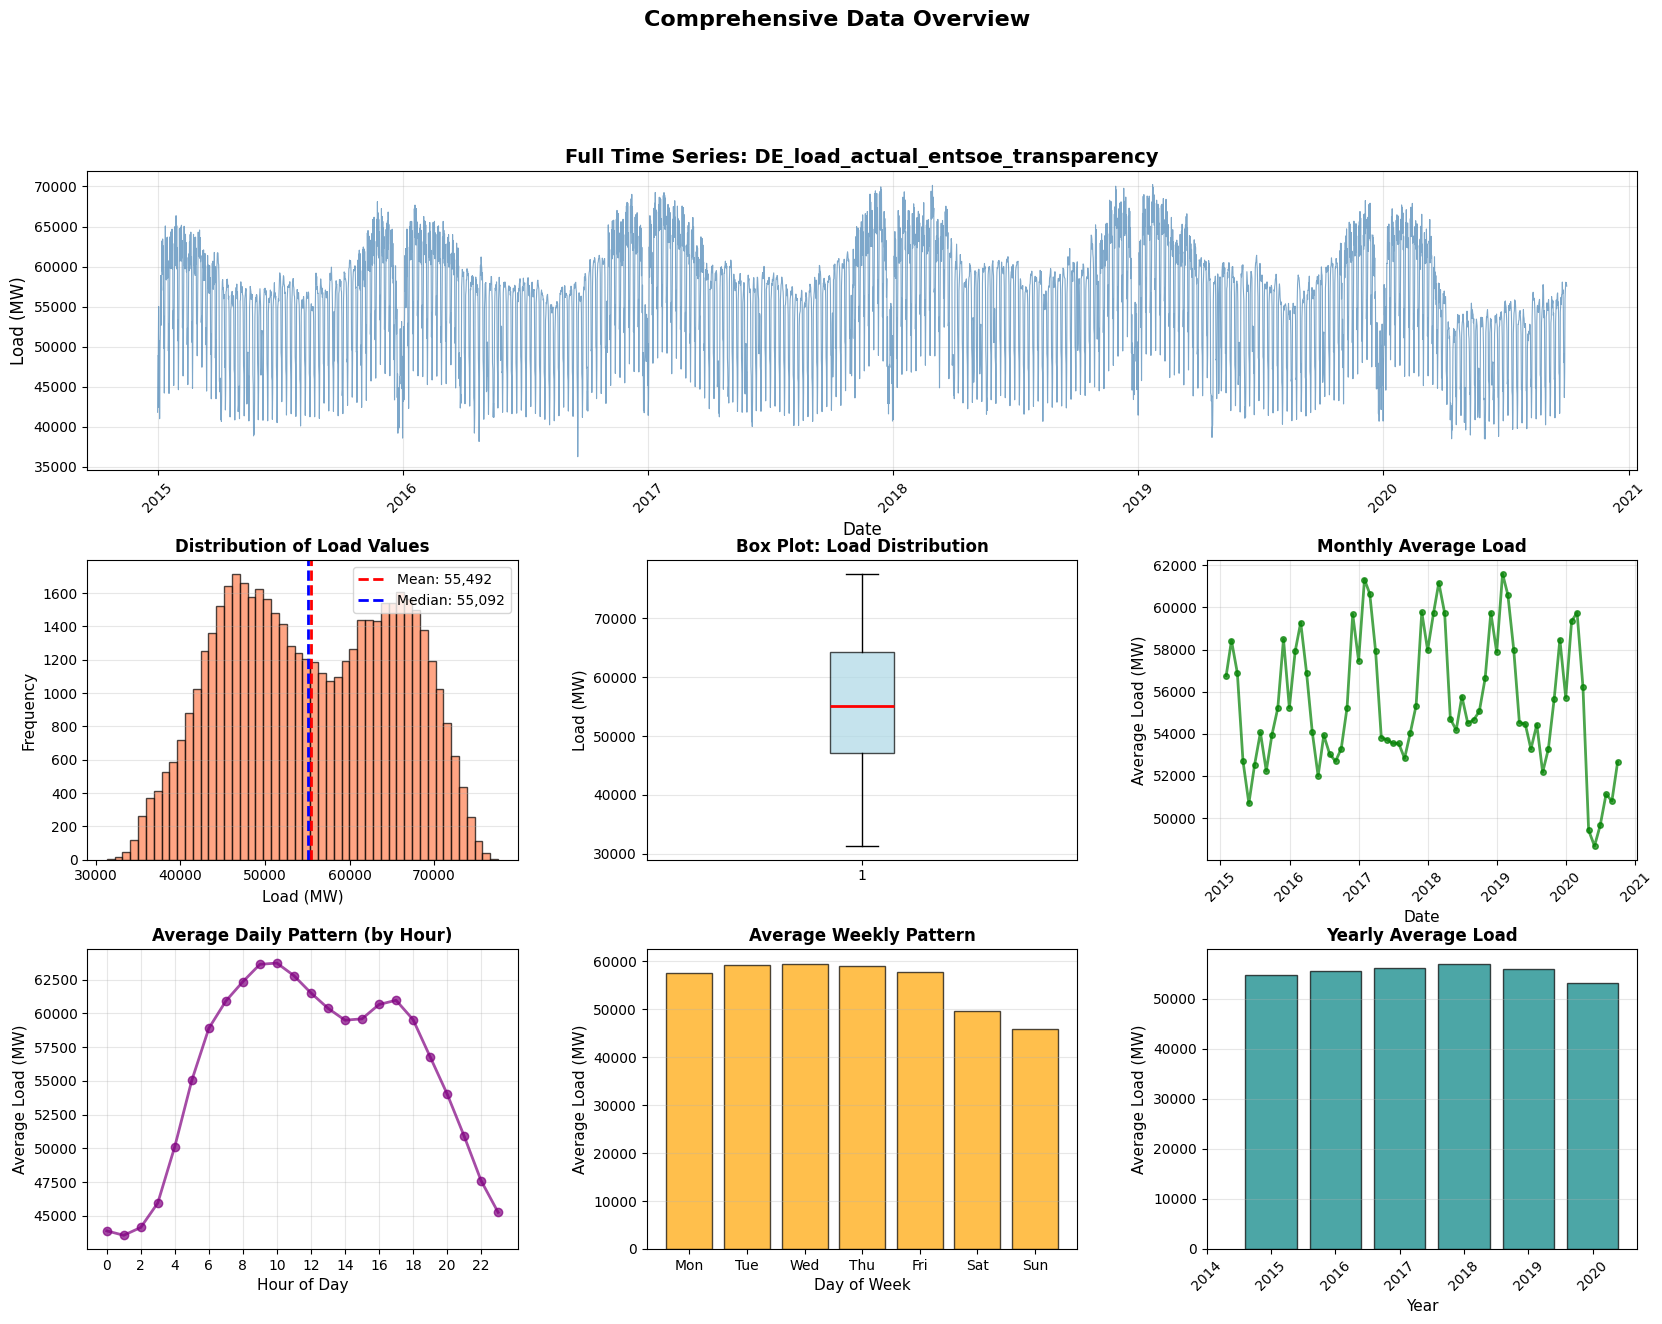


✓ Initial data visualization complete


In [ ]:
# Initial Data Visualization
print("="*80)
print("INITIAL DATA VISUALIZATION")
print("="*80)

# Check if target_load exists, otherwise use first load column
if 'target_load' in df.columns:
    target_col = 'target_load'
elif 'DE_load_actual_entsoe_transparency' in df.columns:
    target_col = 'DE_load_actual_entsoe_transparency'
else:
    load_cols = [col for col in df.columns if 'load' in col.lower() and 'actual' in col.lower()]
    target_col = load_cols[0] if load_cols else None

if target_col and target_col in df.columns:
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Full time series
    ax1 = fig.add_subplot(gs[0, :])
    sample_data = df[target_col].dropna()
    if len(sample_data) > 10000:
        # Sample for faster plotting
        sample_data = sample_data.resample('12H').mean()
    ax1.plot(sample_data.index, sample_data.values, linewidth=0.8, alpha=0.7, color='steelblue')
    ax1.set_title(f'Full Time Series: {target_col}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Load (MW)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Distribution
    ax2 = fig.add_subplot(gs[1, 0])
    data_clean = df[target_col].dropna()
    ax2.hist(data_clean, bins=50, color='coral', alpha=0.7, edgecolor='black')
    ax2.axvline(data_clean.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data_clean.mean():,.0f}')
    ax2.axvline(data_clean.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {data_clean.median():,.0f}')
    ax2.set_title('Distribution of Load Values', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Load (MW)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Box plot
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.boxplot(data_clean, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax3.set_title('Box Plot: Load Distribution', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Load (MW)', fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Monthly average
    ax4 = fig.add_subplot(gs[1, 2])
    monthly_avg = df[target_col].resample('M').mean()
    ax4.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=4, color='green', alpha=0.7)
    ax4.set_title('Monthly Average Load', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_ylabel('Average Load (MW)', fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Daily pattern (hourly average)
    ax5 = fig.add_subplot(gs[2, 0])
    if df.index.tz is not None:
        df_temp = df.copy()
        df_temp['hour'] = df_temp.index.hour
    else:
        df_temp = df.copy()
        df_temp['hour'] = pd.to_datetime(df_temp.index).hour
    hourly_avg = df_temp.groupby('hour')[target_col].mean()
    ax5.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6, color='purple', alpha=0.7)
    ax5.set_title('Average Daily Pattern (by Hour)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Hour of Day', fontsize=11)
    ax5.set_ylabel('Average Load (MW)', fontsize=11)
    ax5.set_xticks(range(0, 24, 2))
    ax5.grid(True, alpha=0.3)
    
    # 6. Weekly pattern
    ax6 = fig.add_subplot(gs[2, 1])
    df_temp['day_of_week'] = df_temp.index.dayofweek
    daily_avg = df_temp.groupby('day_of_week')[target_col].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax6.bar(range(7), daily_avg.values, color='orange', alpha=0.7, edgecolor='black')
    ax6.set_xticks(range(7))
    ax6.set_xticklabels(day_names)
    ax6.set_title('Average Weekly Pattern', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Day of Week', fontsize=11)
    ax6.set_ylabel('Average Load (MW)', fontsize=11)
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Yearly trend
    ax7 = fig.add_subplot(gs[2, 2])
    yearly_avg = df[target_col].resample('Y').mean()
    ax7.bar(range(len(yearly_avg)), yearly_avg.values, color='teal', alpha=0.7, edgecolor='black')
    ax7.set_xticks(range(len(yearly_avg)))
    ax7.set_xticklabels([str(y.year) for y in yearly_avg.index], rotation=45)
    ax7.set_title('Yearly Average Load', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Year', fontsize=11)
    ax7.set_ylabel('Average Load (MW)', fontsize=11)
    ax7.grid(True, alpha=0.3, axis='y')
    plt.suptitle('Comprehensive Data Overview', fontsize=16, fontweight='bold', y=0.995)
    plt.show()
    print("\n✓ Initial data visualization complete")
    print("="*80)
else:
    print("Warning: Target load column not found for visualization")


In [ ]:
# Load data with proper timestamp parsing
data_path = '../opsd-time_series-2020-10-06/time_series_60min_singleindex.csv'
print(f"\nLoading data from: {data_path}")
df = pd.read_csv(
    data_path,
    parse_dates=['utc_timestamp', 'cet_cest_timestamp'],
    low_memory=False
)

print(f"\nData loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['utc_timestamp'].min()} to {df['utc_timestamp'].max()}")
print(f"Time span: {(df['utc_timestamp'].max() - df['utc_timestamp'].min()).days} days")

# Set UTC timestamp as index
df.set_index('utc_timestamp', inplace=True)
df.sort_index(inplace=True)

# Filter dataset to keep only data from 2015 to September 2018 (before DE_LU starts)
# This eliminates temporal imbalance completely - all 4 control regions exist throughout
START_DATE = pd.Timestamp('2015-01-01')
END_DATE = pd.Timestamp('2018-09-30 23:59:59')
if df.index.tz is not None:
    START_DATE = pd.Timestamp('2015-01-01', tz=df.index.tz)
    END_DATE = pd.Timestamp('2018-09-30 23:59:59', tz=df.index.tz)

initial_rows = len(df)
df = df[(df.index >= START_DATE) & (df.index <= END_DATE)].copy()
filtered_rows = len(df)
rows_removed = initial_rows - filtered_rows

print(f"\nFiltered dataset to period before DE_LU starts (2015-01-01 to 2018-09-30)")
print(f"Rows before filter: {initial_rows:,}")
print(f"Rows after filter: {filtered_rows:,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed/initial_rows*100:.1f}%)")
print(f"New date range: {df.index.min()} to {df.index.max()}")
print(f"New time span: {(df.index.max() - df.index.min()).days} days")
print(f"Note: DE_LU excluded (doesn't exist in this period)")

# Store initial statistics
initial_stats = {
    'shape': df.shape,
    'date_range': {
        'start': str(df.index.min()),
        'end': str(df.index.max())
    },
    'total_columns': len(df.columns),
    'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
}

print(f"\nInitial Statistics:")

print(f"\nFirst few rows:")
df.head()



Loading data from: ../opsd-time_series-2020-10-06/time_series_60min_singleindex.csv

Data loaded successfully!
Shape: 50,401 rows × 300 columns
Date range: 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Time span: 2100 days

Filtered dataset to period before DE_LU starts (2015-01-01 to 2018-09-30)
Rows before filter: 50,401
Rows after filter: 32,856
Rows removed: 17,545 (34.8%)
New date range: 2015-01-01 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
New time span: 1368 days
Note: DE_LU excluded (doesn't exist in this period)

Initial Statistics:

First few rows:


,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,BG_load_forecast_entsoe_transparency,BG_solar_generation_actual,BG_wind_onshore_generation_actual,CH_load_actual_entsoe_transparency,CH_load_forecast_entsoe_transparency,CH_solar_capacity,CH_solar_generation_actual,CH_wind_onshore_capacity,CH_wind_onshore_generation_actual,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,CZ_load_actual_entsoe_transparency,CZ_load_forecast_entsoe_transparency,CZ_solar_generation_actual,CZ_wind_onshore_generation_actual,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,DK_solar_capacity,DK_solar_generation_actual,DK_wind_capacity,DK_wind_generation_actual,DK_wind_offshore_capacity,DK_wind_offshore_generation_actual,DK_wind_onshore_capacity,DK_wind_onshore_generation_actual,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,DK_1_price_day_ahead,DK_1_solar_generation_actual,DK_1_wind_generation_actual,DK_1_wind_offshore_generation_actual,DK_1_wind_onshore_generation_actual,DK_2_load_actual_entsoe_transparency,DK_2_load_forecast_entsoe_transparency,DK_2_price_day_ahead,DK_2_solar_generation_actual,DK_2_wind_generation_actual,DK_2_wind_offshore_generation_actual,DK_2_wind_onshore_generation_actual,EE_load_actual_entsoe_transparency,EE_load_forecast_entsoe_transparency,EE_solar_generation_actual,EE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_load_forecast_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FI_load_actual_entsoe_transparency,FI_load_forecast_entsoe_transparency,FI_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_GBN_load_actual_entsoe_transparency,GB_GBN_load_forecast_entsoe_transparency,GB_GBN_price_day_ahead,GB_GBN_solar_capacity,GB_GBN_solar_generation_actual,GB_GBN_solar_profile,GB_GBN_wind_capacity,GB_GBN_wind_generation_actual,GB_GBN_wind_profile,GB_GBN_wind_offshore_capacity,GB_GBN_wind_offshore_generation_actual,GB_GBN_wind_offshore_profile,GB_GBN_wind_onshore_capacity,GB_GBN_wind_onshore_generation_actual,GB_GBN_wind_onshor

---

## Step 1.2: Weather Data Integration

Load and merge weather data from renewable.ninja (MERRA-2 reanalysis) with the electricity dataset.


In [ ]:
# Load weather data
weather_file = "weather_data_germany_renewable_ninja_pop_wtd_2015_2018.csv"

try:
    df_weather = pd.read_csv(weather_file, index_col=0, parse_dates=True)
    print(f"Weather data loaded: {df_weather.shape[0]:,} rows, {df_weather.shape[1]} columns")
    print(f"Date range: {df_weather.index.min()} to {df_weather.index.max()}")
    
    # Check for missing values
    missing_weather = df_weather.isnull().sum().sum()
    if missing_weather > 0:
        print(f"Warning: {missing_weather} missing values found")
    
    # Ensure timezone alignment
    if df_weather.index.tz is None and df.index.tz is not None:
        df_weather.index = df_weather.index.tz_localize('UTC')
    elif df_weather.index.tz != df.index.tz:
        df_weather.index = df_weather.index.tz_convert(df.index.tz)
    
    # Check timestamp alignment
    missing_in_weather = df.index.difference(df_weather.index)
    extra_in_weather = df_weather.index.difference(df.index)
    
    if len(missing_in_weather) > 0 or len(extra_in_weather) > 0:
        print(f"Timestamp misalignment: {len(missing_in_weather)} missing, {len(extra_in_weather)} extra")
        if len(missing_in_weather) > 0:
            print(f"Missing timestamps (first 5): {list(missing_in_weather[:5])}")
        
        # Filter electricity data to match weather data range
        weather_end = df_weather.index.max()
        elec_before_filter = len(df)
        df = df[df.index <= weather_end].copy()
        rows_filtered = elec_before_filter - len(df)
        
        if rows_filtered > 0:
            print(f"Filtered electricity data: removed {rows_filtered} rows to match weather range")
    
    # Merge weather data
    df = df.join(df_weather, how='inner')
    print(f"Merged: {df.shape[0]:,} rows, {df.shape[1]} columns")
    
except FileNotFoundError:
    print(f"Weather data file not found: {weather_file}")
except Exception as e:
    print(f"Failed to load weather data: {str(e)}")

df.head()


Weather data file not found: weather_data_germany_renewable_ninja_pop_wtd_2015_2018.csv


,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,BG_load_forecast_entsoe_transparency,BG_solar_generation_actual,BG_wind_onshore_generation_actual,CH_load_actual_entsoe_transparency,CH_load_forecast_entsoe_transparency,CH_solar_capacity,CH_solar_generation_actual,CH_wind_onshore_capacity,CH_wind_onshore_generation_actual,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,CZ_load_actual_entsoe_transparency,CZ_load_forecast_entsoe_transparency,CZ_solar_generation_actual,CZ_wind_onshore_generation_actual,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile,DE_50hertz_load_actual_entsoe_transparency,DE_50hertz_load_forecast_entsoe_transparency,DE_50hertz_solar_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_load_actual_entsoe_transparency,DE_LU_load_forecast_entsoe_transparency,DE_LU_price_day_ahead,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_load_actual_entsoe_transparency,DE_amprion_load_forecast_entsoe_transparency,DE_amprion_solar_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,DK_solar_capacity,DK_solar_generation_actual,DK_wind_capacity,DK_wind_generation_actual,DK_wind_offshore_capacity,DK_wind_offshore_generation_actual,DK_wind_onshore_capacity,DK_wind_onshore_generation_actual,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,DK_1_price_day_ahead,DK_1_solar_generation_actual,DK_1_wind_generation_actual,DK_1_wind_offshore_generation_actual,DK_1_wind_onshore_generation_actual,DK_2_load_actual_entsoe_transparency,DK_2_load_forecast_entsoe_transparency,DK_2_price_day_ahead,DK_2_solar_generation_actual,DK_2_wind_generation_actual,DK_2_wind_offshore_generation_actual,DK_2_wind_onshore_generation_actual,EE_load_actual_entsoe_transparency,EE_load_forecast_entsoe_transparency,EE_solar_generation_actual,EE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_load_forecast_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FI_load_actual_entsoe_transparency,FI_load_forecast_entsoe_transparency,FI_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_GBN_load_actual_entsoe_transparency,GB_GBN_load_forecast_entsoe_transparency,GB_GBN_price_day_ahead,GB_GBN_solar_capacity,GB_GBN_solar_generation_actual,GB_GBN_solar_profile,GB_GBN_wind_capacity,GB_GBN_wind_generation_actual,GB_GBN_wind_profile,GB_GBN_wind_offshore_capacity,GB_GBN_wind_offshore_generation_actual,GB_GBN_wind_offshore_profile,GB_GBN_wind_onshore_capacity,GB_GBN_wind_onshore_generation_actual,GB_GBN_wind_onshor

---

## Step 2: Missing Data Analysis

Analyze missing data patterns to understand data quality and guide imputation strategy.


---

## Step 2.1: Missing Data Visualization

Create comprehensive visualizations to understand missing data patterns.


MISSING DATA VISUALIZATION


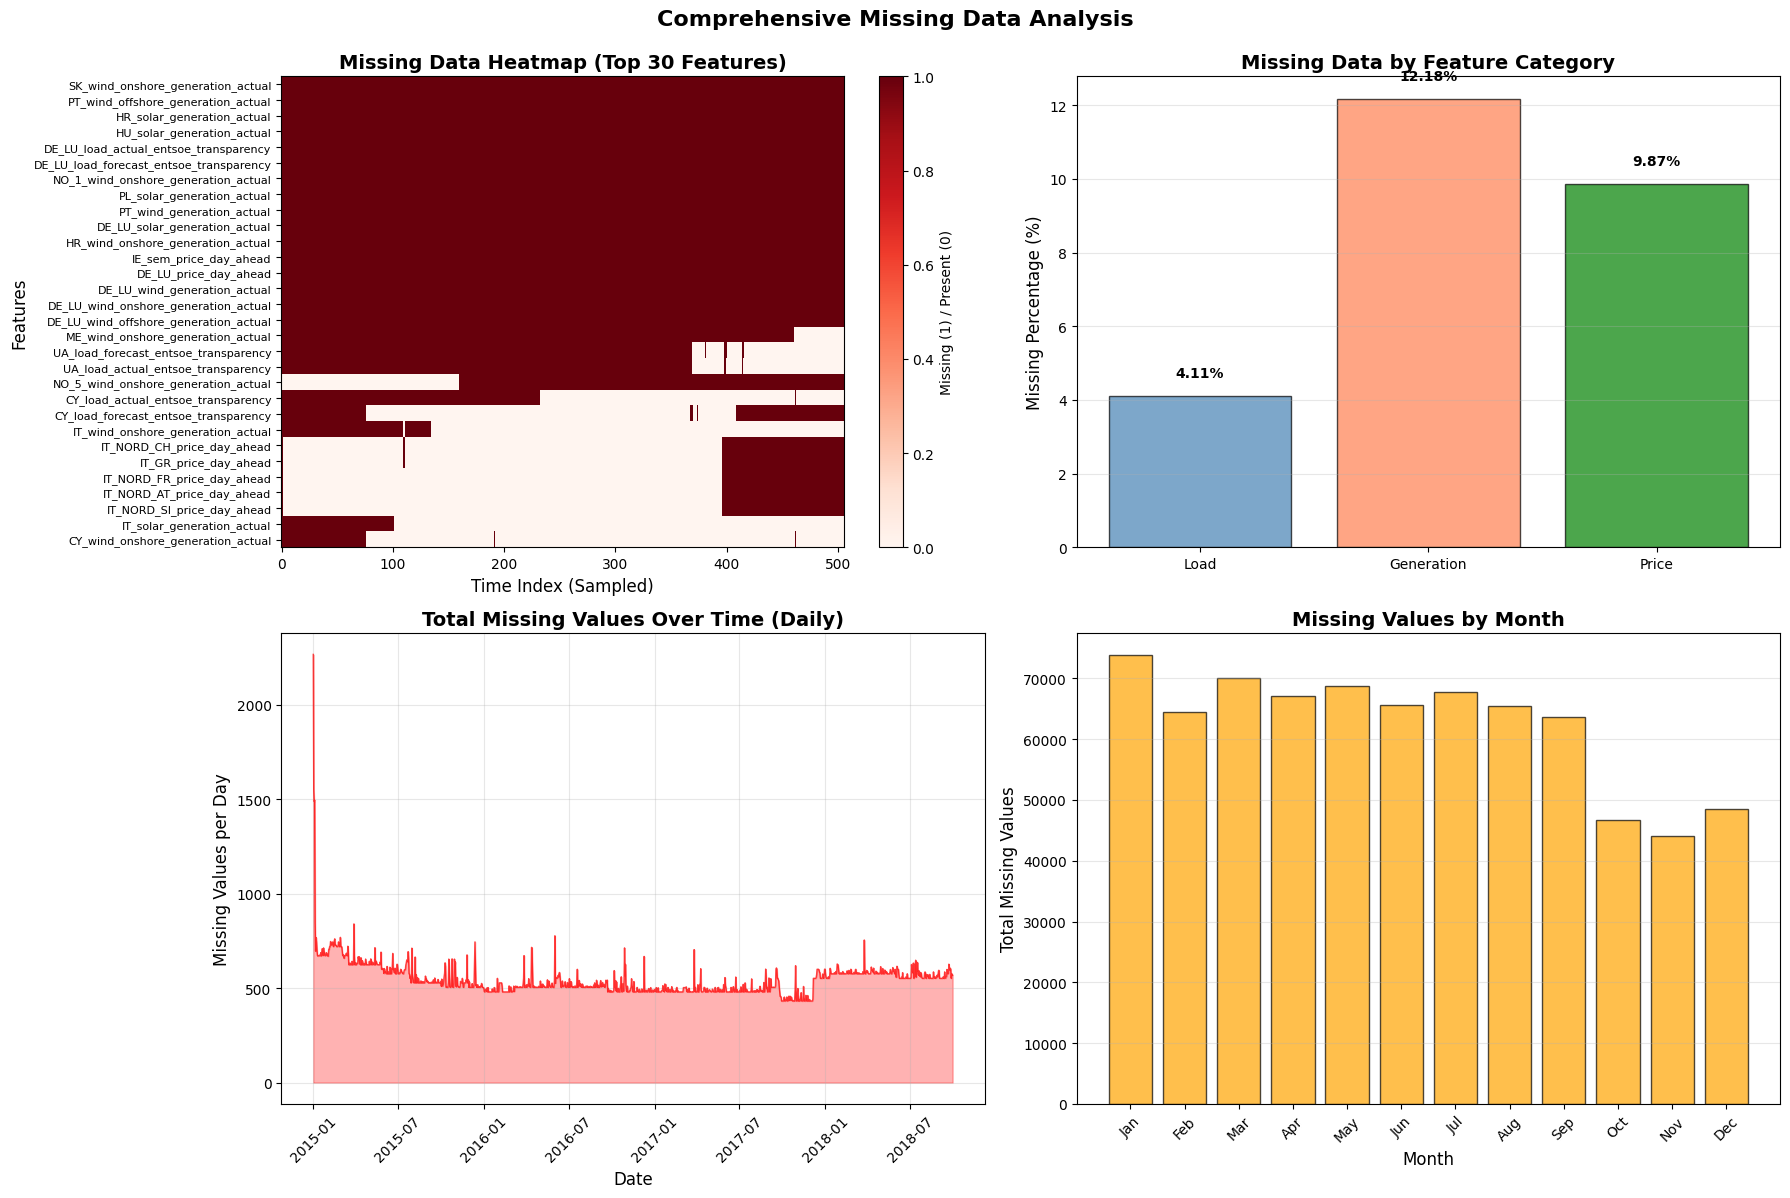


✓ Missing data visualization complete


In [ ]:
# Missing Data Visualization
print("="*80)
print("MISSING DATA VISUALIZATION")
print("="*80)

# Create missing data heatmap for top features
numeric_cols = df.select_dtypes(include=[np.number]).columns
missing_data = df[numeric_cols].isnull()

# Select top 30 features with missing data for heatmap
missing_counts = missing_data.sum().sort_values(ascending=False)
top_missing_cols = missing_counts[missing_counts > 0].head(30).index.tolist()

if len(top_missing_cols) > 0:
    # Sample time periods for heatmap (too many rows otherwise)
    sample_indices = df.index[::max(1, len(df)//500)]  # Sample ~500 points
    missing_sample = missing_data.loc[sample_indices, top_missing_cols]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Missing data heatmap
    ax1 = axes[0, 0]
    if len(missing_sample) > 0 and len(top_missing_cols) > 0:
        im = ax1.imshow(missing_sample.T.astype(int), aspect='auto', cmap='Reds', interpolation='nearest')
        ax1.set_title('Missing Data Heatmap (Top 30 Features)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time Index (Sampled)', fontsize=12)
        ax1.set_ylabel('Features', fontsize=12)
        ax1.set_yticks(range(len(top_missing_cols)))
        ax1.set_yticklabels([col[:40] + '...' if len(col) > 40 else col for col in top_missing_cols], fontsize=8)
        plt.colorbar(im, ax=ax1, label='Missing (1) / Present (0)')
    
    # 2. Missing percentage by feature type
    ax2 = axes[0, 1]
    load_cols = [col for col in numeric_cols if 'load' in col.lower()]
    gen_cols = [col for col in numeric_cols if 'generation' in col.lower()]
    price_cols = [col for col in numeric_cols if 'price' in col.lower()]
    weather_cols = [col for col in numeric_cols if any(x in col for x in ['temperature', 'wind_speed', 'humidity', 'precipitation', 'cloud_cover', 'solar_radiation', 'air_density'])]
    
    categories = []
    missing_pcts = []
    if load_cols:
        categories.append('Load')
        missing_pcts.append(missing_data[load_cols].sum().sum() / (len(df) * len(load_cols)) * 100)
    if gen_cols:
        categories.append('Generation')
        missing_pcts.append(missing_data[gen_cols].sum().sum() / (len(df) * len(gen_cols)) * 100)
    if price_cols:
        categories.append('Price')
        missing_pcts.append(missing_data[price_cols].sum().sum() / (len(df) * len(price_cols)) * 100)
    if weather_cols:
        categories.append('Weather')
        missing_pcts.append(missing_data[weather_cols].sum().sum() / (len(df) * len(weather_cols)) * 100)
    
    if categories:
        ax2.bar(categories, missing_pcts, color=['steelblue', 'coral', 'green', 'purple'][:len(categories)], 
                alpha=0.7, edgecolor='black')
        ax2.set_title('Missing Data by Feature Category', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Missing Percentage (%)', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(missing_pcts):
            ax2.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # 3. Missing data over time
    ax3 = axes[1, 0]
    missing_over_time = missing_data.sum(axis=1).resample('D').sum()
    ax3.plot(missing_over_time.index, missing_over_time.values, linewidth=1, color='red', alpha=0.7)
    ax3.fill_between(missing_over_time.index, 0, missing_over_time.values, alpha=0.3, color='red')
    ax3.set_title('Total Missing Values Over Time (Daily)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Missing Values per Day', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Missing data by month
    ax4 = axes[1, 1]
    df_temp = df.copy()
    df_temp['month'] = df_temp.index.month
    missing_by_month = df_temp.groupby('month')[numeric_cols].apply(lambda x: x.isnull().sum().sum())
    ax4.bar(range(1, 13), missing_by_month.values, color='orange', alpha=0.7, edgecolor='black')
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels(month_names, rotation=45)
    ax4.set_title('Missing Values by Month', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month', fontsize=12)
    ax4.set_ylabel('Total Missing Values', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Comprehensive Missing Data Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Missing data visualization complete")
    print("="*80)
else:
    print("No missing data found to visualize")



Overall Missing Data:
Total missing values: 746,023 (7.59%)
Columns with missing data: 252

Missing Data by Category:
Load columns: 4.03% avg missing
Generation columns: 12.18% avg missing
Price columns: 9.87% avg missing

Top 10 columns with most missing data:
                                         Missing_Count  Missing_Percentage
SK_wind_onshore_generation_actual                32856               100.0
PT_wind_offshore_generation_actual               32856               100.0
HR_solar_generation_actual                       32856               100.0
HU_solar_generation_actual                       32856               100.0
DE_LU_load_forecast_entsoe_transparency          32856               100.0
DE_LU_load_actual_entsoe_transparency            32856               100.0
NO_1_wind_onshore_generation_actual              32856               100.0
PL_solar_generation_actual                       32856               100.0
PT_wind_generation_actual                        32856        

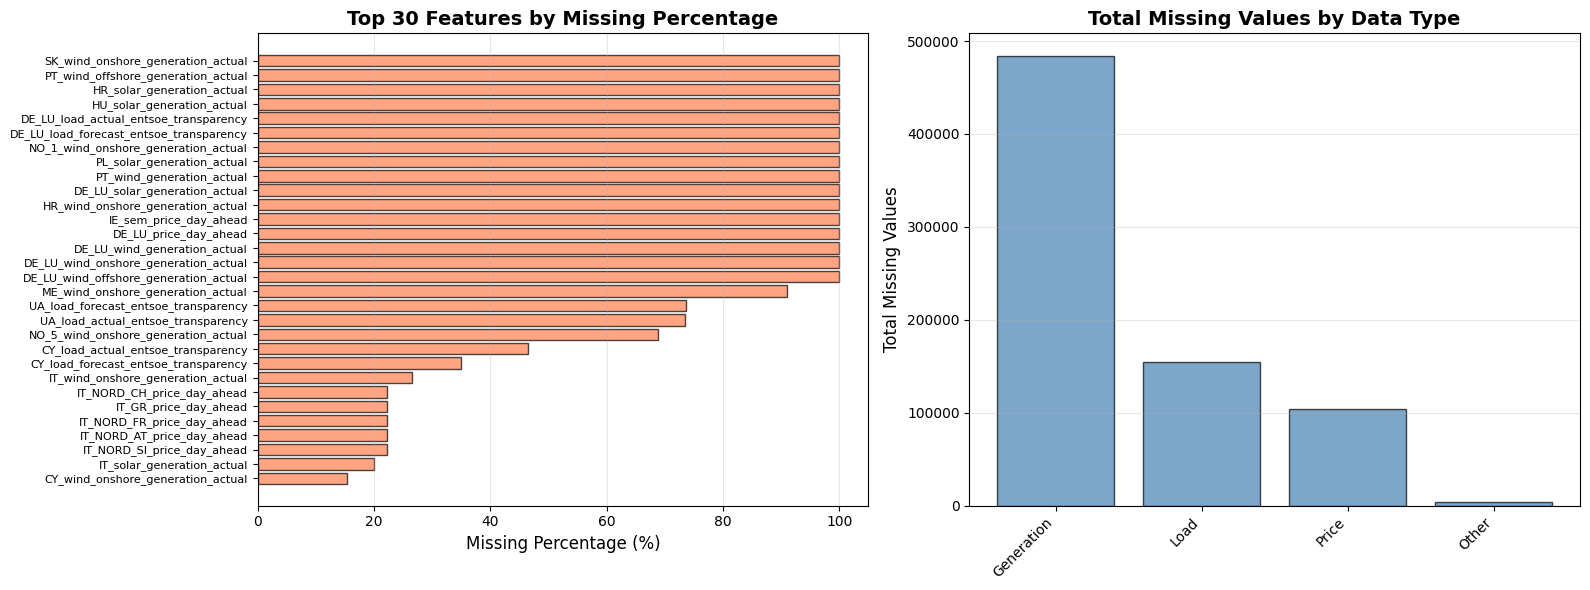


Visualization saved above.


In [ ]:

# Overall missing data statistics
total_cells = df.size
missing_cells = df.isnull().sum().sum()
missing_percentage = (missing_cells / total_cells) * 100

print(f"\nOverall Missing Data:")
print(f"Total missing values: {missing_cells:,} ({missing_percentage:.2f}%)")
print(f"Columns with missing data: {(df.isnull().sum() > 0).sum()}")

# Per-column missing analysis
missing_per_column = df.isnull().sum()
missing_per_column_pct = (missing_per_column / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_per_column,
    'Missing_Percentage': missing_per_column_pct
}).sort_values('Missing_Percentage', ascending=False)

# Identify columns by category
load_cols = [col for col in df.columns if 'load_actual' in col.lower()]
generation_cols = [col for col in df.columns if 'generation' in col.lower()]
price_cols = [col for col in df.columns if 'price' in col.lower()]

print(f"\nMissing Data by Category:")
if load_cols:
    print(f"Load columns: {missing_df.loc[load_cols, 'Missing_Percentage'].mean():.2f}% avg missing")
if generation_cols:
    print(f"Generation columns: {missing_df.loc[generation_cols, 'Missing_Percentage'].mean():.2f}% avg missing")
if price_cols:
    print(f"Price columns: {missing_df.loc[price_cols, 'Missing_Percentage'].mean():.2f}% avg missing")

print(f"\nTop 10 columns with most missing data:")
print(missing_df.head(10))

# Missing values by feature - detailed breakdown
print("\n" + "="*80)
print("MISSING VALUES BY FEATURE")
print("="*80)

# Get numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
missing_by_feature = pd.DataFrame({
    'Feature': numeric_cols,
    'Missing_Count': [df[col].isnull().sum() for col in numeric_cols],
    'Missing_Percentage': [(df[col].isnull().sum() / len(df)) * 100 for col in numeric_cols],
    'Data_Type': ['Load' if 'load' in col.lower() else 
                  'Generation' if 'generation' in col.lower() else
                  'Price' if 'price' in col.lower() else
                  'Weather' if any(x in col for x in ['temperature', 'wind_speed', 'humidity', 'precipitation', 'cloud_cover', 'solar_radiation', 'air_density', 'snowfall', 'snow_mass', 'heating_degree', 'cooling_degree']) else
                  'Other' for col in numeric_cols]
})

# Sort by missing percentage
missing_by_feature = missing_by_feature.sort_values('Missing_Percentage', ascending=False)

# Summary by data type
print("\nMissing Values Summary by Data Type:")
for dtype in missing_by_feature['Data_Type'].unique():
    dtype_data = missing_by_feature[missing_by_feature['Data_Type'] == dtype]
    total_missing = dtype_data['Missing_Count'].sum()
    avg_missing_pct = dtype_data['Missing_Percentage'].mean()
    features_with_missing = (dtype_data['Missing_Count'] > 0).sum()
    print(f"  {dtype}:")
    print(f"    Features with missing values: {features_with_missing}/{len(dtype_data)}")
    print(f"    Total missing values: {total_missing:,}")
    print(f"    Average missing %: {avg_missing_pct:.2f}%")

# Show top features with missing values
print(f"\nTop 20 Features with Most Missing Values:")
print(missing_by_feature[['Feature', 'Missing_Count', 'Missing_Percentage', 'Data_Type']].head(20).to_string(index=False))

# Visualize missing values by feature
if len(missing_by_feature[missing_by_feature['Missing_Count'] > 0]) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Missing percentage by feature (top 30)
    top_missing = missing_by_feature[missing_by_feature['Missing_Count'] > 0].head(30)
    axes[0].barh(range(len(top_missing)), top_missing['Missing_Percentage'], 
                  color='coral', alpha=0.7, edgecolor='black')
    axes[0].set_yticks(range(len(top_missing)))
    axes[0].set_yticklabels([f[:40] + '...' if len(f) > 40 else f for f in top_missing['Feature']], fontsize=8)
    axes[0].set_xlabel('Missing Percentage (%)', fontsize=12)
    axes[0].set_title('Top 30 Features by Missing Percentage', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
    
    # Plot 2: Missing values by data type
    missing_by_type = missing_by_feature.groupby('Data_Type').agg({
        'Missing_Count': 'sum',
        'Feature': 'count'
    }).reset_index()
    missing_by_type.columns = ['Data_Type', 'Total_Missing', 'Total_Features']
    missing_by_type = missing_by_type.sort_values('Total_Missing', ascending=False)
    
    axes[1].bar(range(len(missing_by_type)), missing_by_type['Total_Missing'], 
                color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_xticks(range(len(missing_by_type)))
    axes[1].set_xticklabels(missing_by_type['Data_Type'], rotation=45, ha='right')
    axes[1].set_ylabel('Total Missing Values', fontsize=12)
    axes[1].set_title('Total Missing Values by Data Type', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization saved above.")


---

## Step 3: Feature Selection

Select relevant features for the target country/region.




## Step 3.1: Feature Correlation Visualization

Visualize correlations between selected features to understand relationships.


FEATURE CORRELATION VISUALIZATION


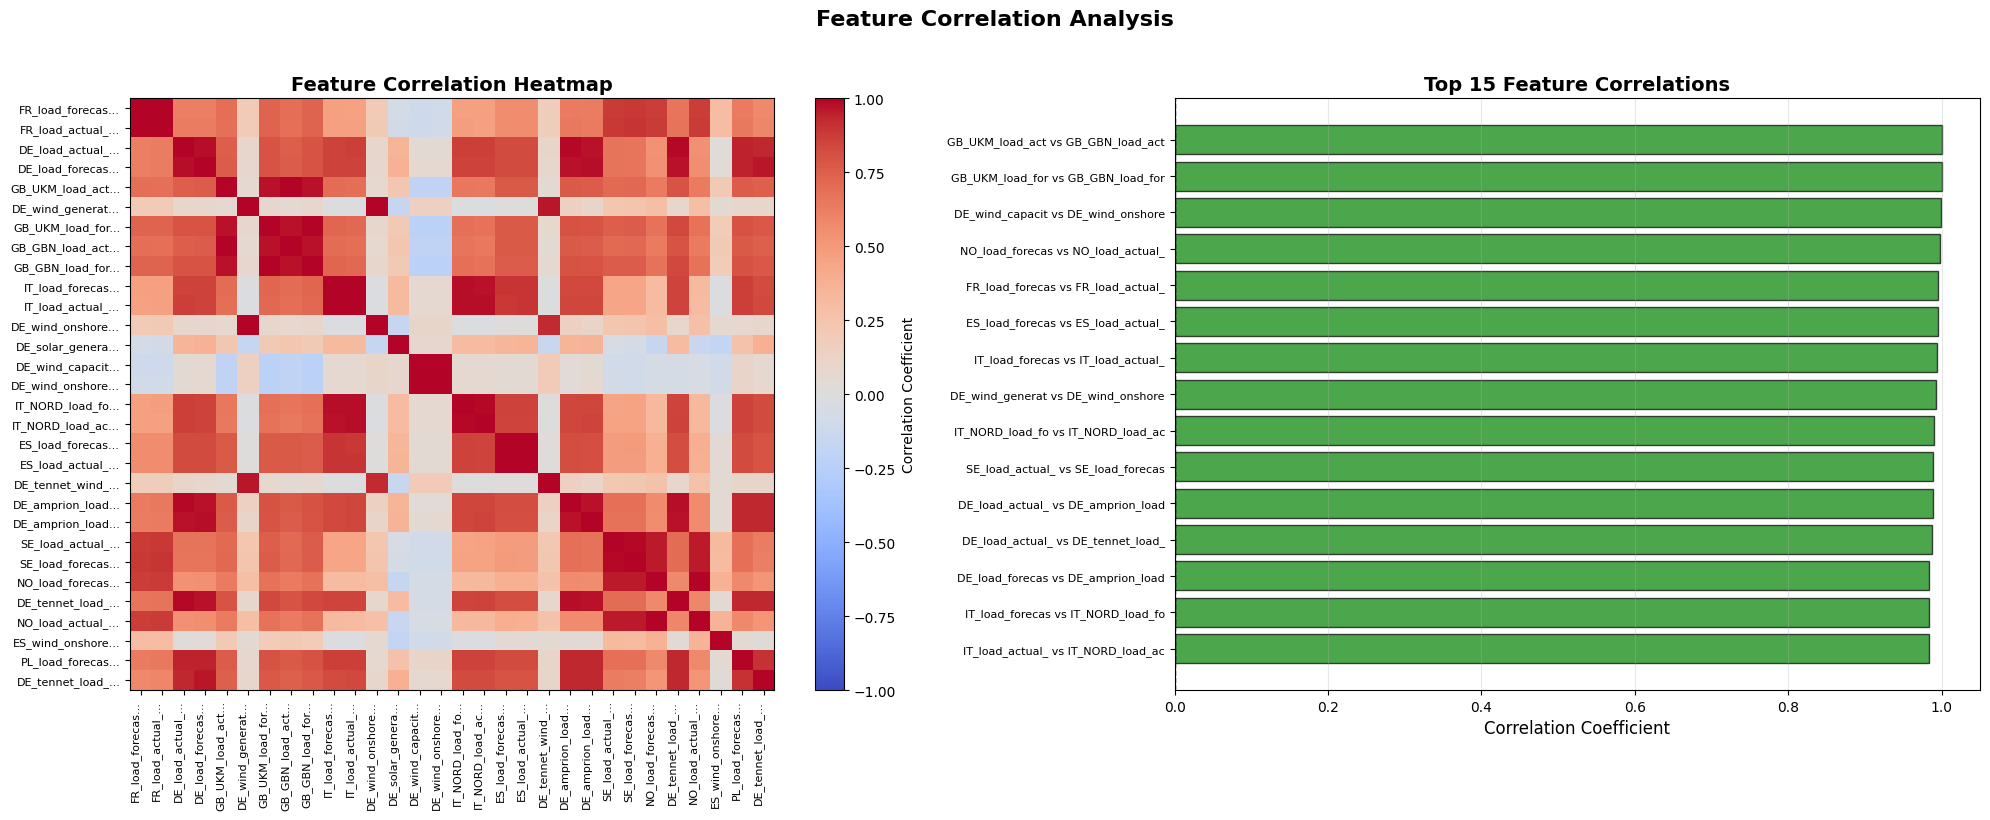


✓ Correlation analysis complete (30 features analyzed)


In [ ]:
# Feature Correlation Visualization
print("="*80)
print("FEATURE CORRELATION VISUALIZATION")
print("="*80)

numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
if len(numeric_cols) > 1:
    # Limit to top 30 features for readability
    if len(numeric_cols) > 30:
        # Select features with highest variance or most important
        variances = df[numeric_cols].var().sort_values(ascending=False)
        top_features = variances.head(30).index.tolist()
        if 'target_load' in numeric_cols and 'target_load' not in top_features:
            top_features = ['target_load'] + top_features[:29]
        corr_cols = top_features
    else:
        corr_cols = numeric_cols.tolist()
    
    corr_matrix = df[corr_cols].corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Full correlation heatmap
    ax1 = axes[0]
    im1 = ax1.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax1.set_xticks(range(len(corr_cols)))
    ax1.set_yticks(range(len(corr_cols)))
    ax1.set_xticklabels([col[:15] + '...' if len(col) > 15 else col for col in corr_cols], 
                        rotation=90, fontsize=8, ha='right')
    ax1.set_yticklabels([col[:15] + '...' if len(col) > 15 else col for col in corr_cols], 
                        fontsize=8)
    ax1.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=ax1, label='Correlation Coefficient')
    
    # 2. Correlation with target (if exists)
    ax2 = axes[1]
    if 'target_load' in corr_cols:
        target_corr = corr_matrix['target_load'].drop('target_load').sort_values(ascending=False)
        top_corr = target_corr.head(15)
        bottom_corr = target_corr.tail(15)
        combined_corr = pd.concat([top_corr, bottom_corr])
        
        colors = ['green' if x > 0 else 'red' for x in combined_corr.values]
        ax2.barh(range(len(combined_corr)), combined_corr.values, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_yticks(range(len(combined_corr)))
        ax2.set_yticklabels([col[:30] + '...' if len(col) > 30 else col for col in combined_corr.index], fontsize=9)
        ax2.set_xlabel('Correlation with Target Load', fontsize=12)
        ax2.set_title('Top 15 Positive & Negative Correlations with Target', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='x')
        ax2.invert_yaxis()
    else:
        # If no target, show strongest correlations overall
        corr_upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        strong_corr = []
        for col in corr_upper.columns:
            for idx in corr_upper.index:
                if not pd.isna(corr_upper.loc[idx, col]):
                    strong_corr.append((idx, col, corr_upper.loc[idx, col]))
        
        strong_corr_df = pd.DataFrame(strong_corr, columns=['Feature1', 'Feature2', 'Correlation'])
        strong_corr_df = strong_corr_df.reindex(strong_corr_df['Correlation'].abs().sort_values(ascending=False).index)
        top_15 = strong_corr_df.head(15)
        
        ax2.barh(range(len(top_15)), top_15['Correlation'].values, 
                color=['green' if x > 0 else 'red' for x in top_15['Correlation'].values],
                alpha=0.7, edgecolor='black')
        ax2.set_yticks(range(len(top_15)))
        ax2.set_yticklabels([f"{row['Feature1'][:15]} vs {row['Feature2'][:15]}" 
                            for _, row in top_15.iterrows()], fontsize=8)
        ax2.set_xlabel('Correlation Coefficient', fontsize=12)
        ax2.set_title('Top 15 Feature Correlations', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='x')
        ax2.invert_yaxis()
    
    plt.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Correlation analysis complete ({len(corr_cols)} features analyzed)")
    print("="*80)
else:
    print("Not enough numeric features for correlation analysis")


In [ ]:

# Find all columns related to target country
if '_' in target_country:
    country_cols = [col for col in df.columns if col.startswith(target_country + '_')]
else:
    country_cols = [col for col in df.columns if col.startswith(target_country + '_')]

# If no columns found, try flexible matching
if len(country_cols) == 0:
    country_parts = target_country.split('_')
    country_cols = [col for col in df.columns if any(col.startswith(part + '_') for part in country_parts)]

print(f"\nFeatures for {target_country}:")
print(f"Found {len(country_cols)} columns")

# Identify key feature types
target_load = None
load_cols = []
solar_cols = []
wind_cols = []
price_cols = []

# Define control region prefixes (exclude DE_LU - dataset covers 2015-2018, before DE_LU starts)
control_region_prefixes = ['DE_50hertz_', 'DE_amprion_', 'DE_tennet_', 'DE_transnetbw_']

for col in country_cols:
    if 'load_actual' in col.lower():
        load_cols.append(col)
        if target_region in col:
            target_load = col
    elif 'solar' in col.lower() and 'generation' in col.lower():
        # Include all control region solar columns (including DE_LU)
        solar_cols.append(col)
    elif 'wind' in col.lower() and 'generation' in col.lower():
        # Include all control region wind columns (including DE_LU)
        wind_cols.append(col)
    elif 'price' in col.lower():
        # Include all control region price columns (including DE_LU)
        price_cols.append(col)

print(f"Load columns: {len(load_cols)}")
print(f"Solar generation: {len(solar_cols)}")
print(f"Wind generation: {len(wind_cols)}")
print(f"Price columns: {len(price_cols)}")
print(f"Note: DE_LU excluded (dataset covers 2015-2018, before DE_LU starts)")

if target_load is None:
    if load_cols:
        target_load = load_cols[0]
        print(f"\nWarning: Target region '{target_region}' not found.")
        print(f"  Using first available load column: {target_load}")
    else:
        raise ValueError(f"No load columns found for {target_country}")

# Filter load_cols to only include control region load columns (including DE_LU, but exclude main DE)
control_region_load_cols = []
for col in load_cols:
    # Include if it's from a control region (including DE_LU, but not main DE)
    if any(col.startswith(prefix) and 'load_actual' in col for prefix in control_region_prefixes):
        control_region_load_cols.append(col)

print(f"\nControl region load columns found: {len(control_region_load_cols)}")
if control_region_load_cols:
    print(f"  Control region load columns: {[col.replace('_load_actual_entsoe_transparency', '') for col in control_region_load_cols]}")

# Select features: target + control region loads + solar + wind + price (all exclude DE_LU)
selected_cols = [target_load] + control_region_load_cols + solar_cols + wind_cols + price_cols

# Also include CET timestamp for timezone features
if 'cet_cest_timestamp' in df.columns:
    selected_cols.append('cet_cest_timestamp')

# Include weather variables (from renewable.ninja MERRA-2 data)
weather_cols = [col for col in df.columns if any(x in col for x in ['temperature', 'wind_speed', 'humidity', 'precipitation', 'cloud_cover', 'solar_radiation', 'air_density', 'snowfall', 'snow_mass', 'heating_degree', 'cooling_degree'])]
if weather_cols:
    selected_cols.extend(weather_cols)
    print(f"Weather variables: {len(weather_cols)} columns")
    print(f"    Weather columns: {', '.join(weather_cols[:5])}{'...' if len(weather_cols) > 5 else ''}")

# Create subset
df = df[selected_cols].copy()

# Rename target column
df.rename(columns={target_load: 'target_load'}, inplace=True)

print(f"\nSelected {len(selected_cols)} features")
print(f"Target variable: target_load")
print(f"Control region load columns: {len(control_region_load_cols)}")
print(f"Control region generation columns: {len(solar_cols) + len(wind_cols)}")
if weather_cols:
    print(f"Weather variables: {len(weather_cols)} columns (from renewable.ninja MERRA-2)")
print(f"Note: Dataset covers 2015-2018 (before DE_LU starts) - no temporal imbalance")
print(f"\nSelected columns ({len(selected_cols)} total): {selected_cols[:10]}{'...' if len(selected_cols) > 10 else ''}")



Features for DE:
Found 41 columns
Load columns: 6
Solar generation: 6
Wind generation: 14
Price columns: 1
Note: DE_LU excluded (dataset covers 2015-2018, before DE_LU starts)

Control region load columns found: 4
  Control region load columns: ['DE_50hertz', 'DE_amprion', 'DE_tennet', 'DE_transnetbw']

Selected 27 features
Target variable: target_load
Control region load columns: 4
Control region generation columns: 20
Note: Dataset covers 2015-2018 (before DE_LU starts) - no temporal imbalance

Selected columns (27 total): ['DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DE_solar_generation_actual', 'DE_50hertz_solar_generation_actual', 'DE_LU_solar_generation_actual', 'DE_amprion_solar_generation_actual', 'DE_tennet_solar_generation_actual']...


---

## Step 3.2: Data Coverage and Gaps Analysis (Before Gap Filling)

Analyze temporal coverage and identify gaps in the time series before filling missing timestamps.


In [ ]:
# Store original data before gap filling for comparison
df_before_gap_fill = df.copy()
target_load_col = 'target_load' if 'target_load' in df.columns else None

# Create complete date range with resolution-specific frequency
full_range = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq=expected_freq
)

missing_timestamps = full_range.difference(df.index)

print("="*80)
print("DATA COVERAGE AND GAPS ANALYSIS (BEFORE GAP FILLING)")
print("="*80)

print(f"\nTemporal Coverage:")
print(f"  Start date: {df.index.min()}")
print(f"  End date: {df.index.max()}")
print(f"  Expected timestamps: {len(full_range):,}")
print(f"  Actual timestamps: {len(df):,}")
print(f"  Missing timestamps: {len(missing_timestamps):,}")

if len(missing_timestamps) > 0:
    missing_pct = (len(missing_timestamps) / len(full_range)) * 100
    print(f"  Missing percentage: {missing_pct:.2f}%")
    
    # Analyze gap patterns
    print(f"\nGap Analysis:")
    if len(missing_timestamps) > 0:
        # Find consecutive gaps
        missing_sorted = sorted(missing_timestamps)
        gaps = []
        current_gap = [missing_sorted[0]]
        
        for i in range(1, len(missing_sorted)):
            if (missing_sorted[i] - missing_sorted[i-1]).total_seconds() <= (pd.Timedelta(expected_freq).total_seconds() * 1.5):
                current_gap.append(missing_sorted[i])
            else:
                gaps.append(current_gap)
                current_gap = [missing_sorted[i]]
        gaps.append(current_gap)
        
        gap_lengths = [len(g) for g in gaps]
        print(f"  Number of gap periods: {len(gaps)}")
        print(f"  Largest gap: {max(gap_lengths)} timestamps")
        print(f"  Average gap size: {np.mean(gap_lengths):.2f} timestamps")
        print(f"  Total missing timestamps: {len(missing_timestamps):,}")
        
        # Show first few gaps
        print(f"\n  First 5 gap periods:")
        for i, gap in enumerate(gaps[:5]):
            print(f"    Gap {i+1}: {gap[0]} to {gap[-1]} ({len(gap)} timestamps)")
    
    # Visualize coverage
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Timeline showing gaps
    date_range_plot = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    coverage = pd.Series(0, index=date_range_plot)
    
    for date in date_range_plot:
        day_start = date
        day_end = date + pd.Timedelta(days=1)
        day_timestamps = full_range[(full_range >= day_start) & (full_range < day_end)]
        day_missing = [ts for ts in day_timestamps if ts in missing_timestamps]
        coverage.loc[date] = len(day_missing) / len(day_timestamps) * 100 if len(day_timestamps) > 0 else 0
    
    axes[0].plot(coverage.index, coverage.values, linewidth=1, color='red', alpha=0.7)
    axes[0].fill_between(coverage.index, 0, coverage.values, alpha=0.3, color='red')
    axes[0].set_ylabel('Missing Timestamps (%)', fontsize=12)
    axes[0].set_title('Temporal Coverage: Missing Timestamps by Day (Before Gap Filling)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Date', fontsize=12)
    
    # Plot 2: Monthly summary
    monthly_missing = {}
    for ts in missing_timestamps:
        month_key = ts.strftime('%Y-%m')
        monthly_missing[month_key] = monthly_missing.get(month_key, 0) + 1
    
    monthly_df = pd.DataFrame(list(monthly_missing.items()), columns=['Month', 'Missing_Count'])
    monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])
    monthly_df = monthly_df.sort_values('Month')
    
    if len(monthly_df) > 0:
        axes[1].bar(monthly_df['Month'], monthly_df['Missing_Count'], 
                   color='coral', alpha=0.7, edgecolor='black', width=20)
        axes[1].set_ylabel('Missing Timestamps', fontsize=12)
        axes[1].set_title('Missing Timestamps by Month (Before Gap Filling)', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].set_xlabel('Month', fontsize=12)
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCoverage visualization saved above.")
else:
    print("\n  ✓ No missing timestamps detected - continuous time series")
    print("  ✓ Full temporal coverage from start to end date")

print("="*80)


DATA COVERAGE AND GAPS ANALYSIS (BEFORE GAP FILLING)

Temporal Coverage:
  Start date: 2015-01-01 00:00:00+00:00
  End date: 2018-09-30 23:00:00+00:00
  Expected timestamps: 32,856
  Actual timestamps: 32,856
  Missing timestamps: 0

  ✓ No missing timestamps detected - continuous time series
  ✓ Full temporal coverage from start to end date


---

## Step 4: Timestamp Validation and Gap Filling

Ensure continuous time series by detecting and filling missing timestamps.


In [ ]:
# Timestamp Validation and Gap Filling
print("="*80)
print("TIMESTAMP VALIDATION AND GAP FILLING")
print("="*80)

# Create complete date range
full_range = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq=expected_freq
)

missing_timestamps = full_range.difference(df.index)

print(f"\nTimestamp Validation:")
print(f"  Expected timestamps: {len(full_range):,}")
print(f"  Actual timestamps: {len(df):,}")
print(f"  Missing timestamps: {len(missing_timestamps):,}")

if len(missing_timestamps) > 0:
    missing_pct = (len(missing_timestamps) / len(full_range)) * 100
    print(f"  Missing percentage: {missing_pct:.2f}%")
    
    # Reindex to fill missing timestamps
    df = df.reindex(full_range)
    
    print(f"\nGap Filling:")
    print(f"  Filled {len(missing_timestamps):,} missing timestamps")
    print(f"  New dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"  Missing values after gap filling: {df.isnull().sum().sum():,}")
else:
    print("\n  ✓ No missing timestamps - time series is already continuous")

print("="*80)


---

## Step 5: Outlier Detection Visualization

Visualize detected outliers to understand their distribution and patterns.---
Detect outliers using IQR and Z-score methods to identify extreme values.



In [ ]:
outlier_report = {}
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    if col == 'target_load' or 'generation' in col.lower() or 'load' in col.lower():
        data = df[col].dropna()
        
        if len(data) == 0:
            continue
        
        outliers_iqr = []
        outliers_zscore = []
        
        # Method 1: IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers
        upper_bound = Q3 + 3 * IQR
        outliers_iqr = data[(data < lower_bound) | (data > upper_bound)].index.tolist()
        
        # Method 2: Z-score
        z_scores = np.abs(scipy_stats.zscore(data))
        outliers_zscore = data[z_scores > 3].index.tolist()
        
        # Combine methods
        outliers = list(set(outliers_iqr + outliers_zscore))
        
        outlier_report[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(data) * 100 if len(data) > 0 else 0,
            'method': 'both'
        }

# Print summary
total_outliers = sum([v['count'] for v in outlier_report.values()])
print(f"\nOutlier Detection Summary:")
print(f"Total outliers detected: {total_outliers:,}")
print(f"Columns with outliers: {len(outlier_report)}")

for col, outlier_stats in list(outlier_report.items())[:10]:
    print(f"{col}: {outlier_stats['count']:,} outliers ({outlier_stats['percentage']:.2f}%)")



Outlier Detection Summary:
Total outliers detected: 5,467
Columns with outliers: 24
target_load: 0 outliers (0.00%)
DE_50hertz_load_actual_entsoe_transparency: 111 outliers (0.34%)
DE_amprion_load_actual_entsoe_transparency: 1 outliers (0.00%)
DE_tennet_load_actual_entsoe_transparency: 0 outliers (0.00%)
DE_transnetbw_load_actual_entsoe_transparency: 1 outliers (0.00%)
DE_solar_generation_actual: 356 outliers (1.09%)
DE_50hertz_solar_generation_actual: 472 outliers (1.44%)
DE_amprion_solar_generation_actual: 410 outliers (1.25%)
DE_tennet_solar_generation_actual: 378 outliers (1.15%)
DE_transnetbw_solar_generation_actual: 311 outliers (0.95%)


OUTLIER DETECTION VISUALIZATION


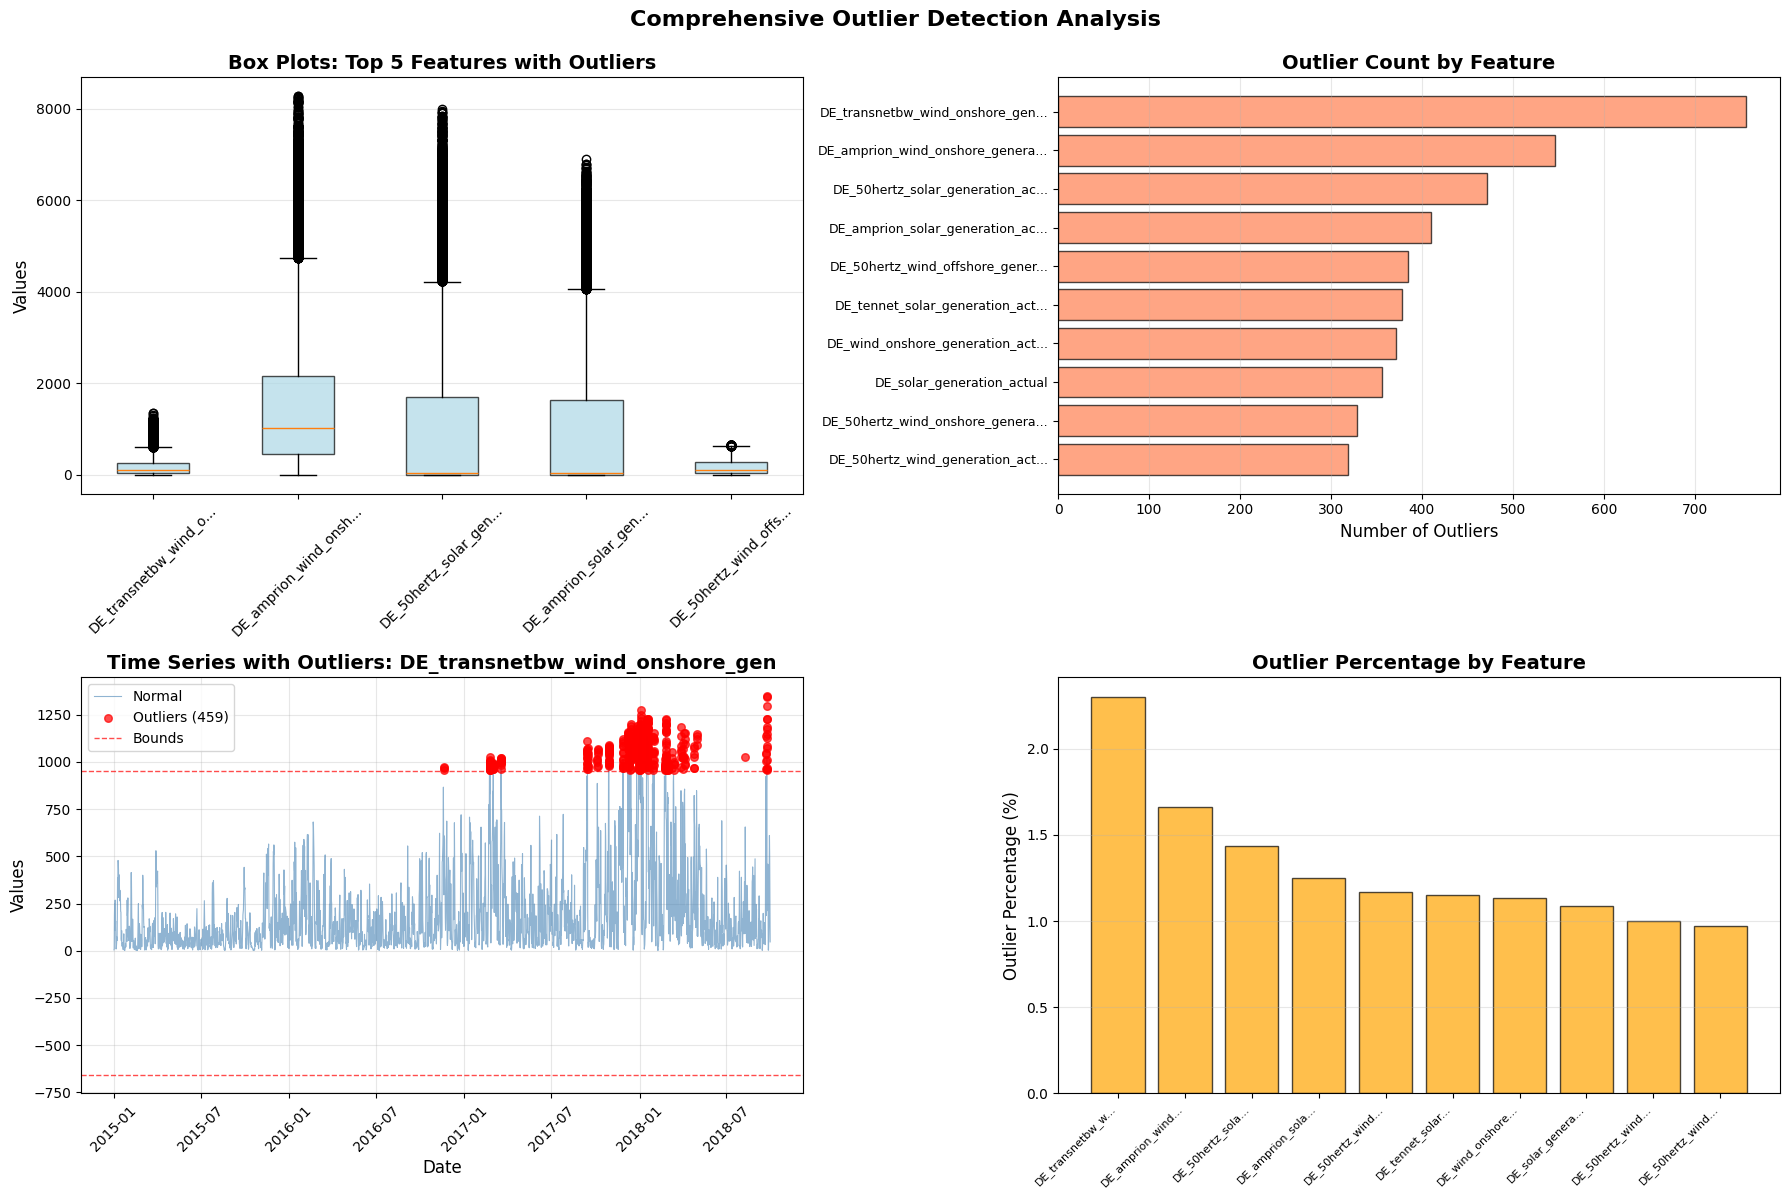


✓ Outlier visualization complete (17 features with outliers)


In [ ]:
# Outlier Detection Visualization
print("="*80)
print("OUTLIER DETECTION VISUALIZATION")
print("="*80)

# Compute outlier_report if it doesn't exist
try:
    _ = outlier_report
except NameError:
    print("Computing outlier report...")
    outlier_report = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col == 'target_load' or 'generation' in col.lower() or 'load' in col.lower():
            data = df[col].dropna()
            
            if len(data) == 0:
                continue
            
            # Method 1: IQR
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            outliers_iqr = data[(data < lower_bound) | (data > upper_bound)].index.tolist()
            
            # Method 2: Z-score
            z_scores = np.abs(scipy_stats.zscore(data))
            outliers_zscore = data[z_scores > 3].index.tolist()
            
            # Combine methods
            outliers = list(set(outliers_iqr + outliers_zscore))
            
            outlier_report[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(data) * 100 if len(data) > 0 else 0,
                'method': 'both'
            }

# Get columns with outliers
cols_with_outliers = [col for col in outlier_report.keys() if outlier_report[col]['count'] > 0]
top_outlier_cols = sorted(cols_with_outliers, key=lambda x: outlier_report[x]['count'], reverse=True)[:10]

if len(top_outlier_cols) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Box plots for top outlier columns
    ax1 = axes[0, 0]
    data_to_plot = [df[col].dropna().values for col in top_outlier_cols[:5]]
    bp = ax1.boxplot(data_to_plot, labels=[col[:20] + '...' if len(col) > 20 else col for col in top_outlier_cols[:5]], 
                     vert=True, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax1.set_title('Box Plots: Top 5 Features with Outliers', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Values', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Outlier count by feature
    ax2 = axes[0, 1]
    outlier_counts = [outlier_report[col]['count'] for col in top_outlier_cols]
    ax2.barh(range(len(top_outlier_cols)), outlier_counts, color='coral', alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(top_outlier_cols)))
    ax2.set_yticklabels([col[:30] + '...' if len(col) > 30 else col for col in top_outlier_cols], fontsize=9)
    ax2.set_xlabel('Number of Outliers', fontsize=12)
    ax2.set_title('Outlier Count by Feature', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.invert_yaxis()
    
    # 3. Time series with outliers highlighted (for first feature with outliers)
    ax3 = axes[1, 0]
    if len(top_outlier_cols) > 0:
        col = top_outlier_cols[0]
        data = df[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Sample for plotting if too many points
        sample_data = data.resample('12H').mean() if len(data) > 5000 else data
        ax3.plot(sample_data.index, sample_data.values, linewidth=0.8, alpha=0.6, color='steelblue', label='Normal')
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        if len(outliers) > 0:
            outlier_sample = outliers.resample('12H').mean() if len(outliers) > 500 else outliers
            ax3.scatter(outlier_sample.index, outlier_sample.values, color='red', s=30, alpha=0.7, 
                       label=f'Outliers ({len(outliers)})', zorder=5)
        
        ax3.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Bounds')
        ax3.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax3.set_title(f'Time Series with Outliers: {col[:30]}', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Date', fontsize=12)
        ax3.set_ylabel('Values', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
    
    # 4. Outlier percentage by feature
    ax4 = axes[1, 1]
    outlier_pcts = [outlier_report[col]['percentage'] for col in top_outlier_cols]
    ax4.bar(range(len(top_outlier_cols)), outlier_pcts, color='orange', alpha=0.7, edgecolor='black')
    ax4.set_xticks(range(len(top_outlier_cols)))
    ax4.set_xticklabels([col[:15] + '...' if len(col) > 15 else col for col in top_outlier_cols], 
                        rotation=45, ha='right', fontsize=8)
    ax4.set_ylabel('Outlier Percentage (%)', fontsize=12)
    ax4.set_title('Outlier Percentage by Feature', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Comprehensive Outlier Detection Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Outlier visualization complete ({len(cols_with_outliers)} features with outliers)")
    print("="*80)
else:
    print("No outliers detected to visualize")


---

## Step 6: Outlier Treatment Visualization
Treat detected outliers by clipping to reasonable bounds.
Compare data before and after outlier treatment.


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
treated_count = 0

for col in numeric_cols:
    if col in outlier_report and outlier_report[col]['count'] > 0:
        data = df[col].dropna()
        
        # Clip to 3*IQR bounds
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        before_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        treated_count += before_count

print(f"\nTreated {treated_count:,} outliers using clip method")
print(f"Method: Clipping to 3×IQR bounds")
print(f"Preserves data distribution while removing extremes")



Treated 835 outliers using clip method
Method: Clipping to 3×IQR bounds
Preserves data distribution while removing extremes


OUTLIER TREATMENT VISUALIZATION


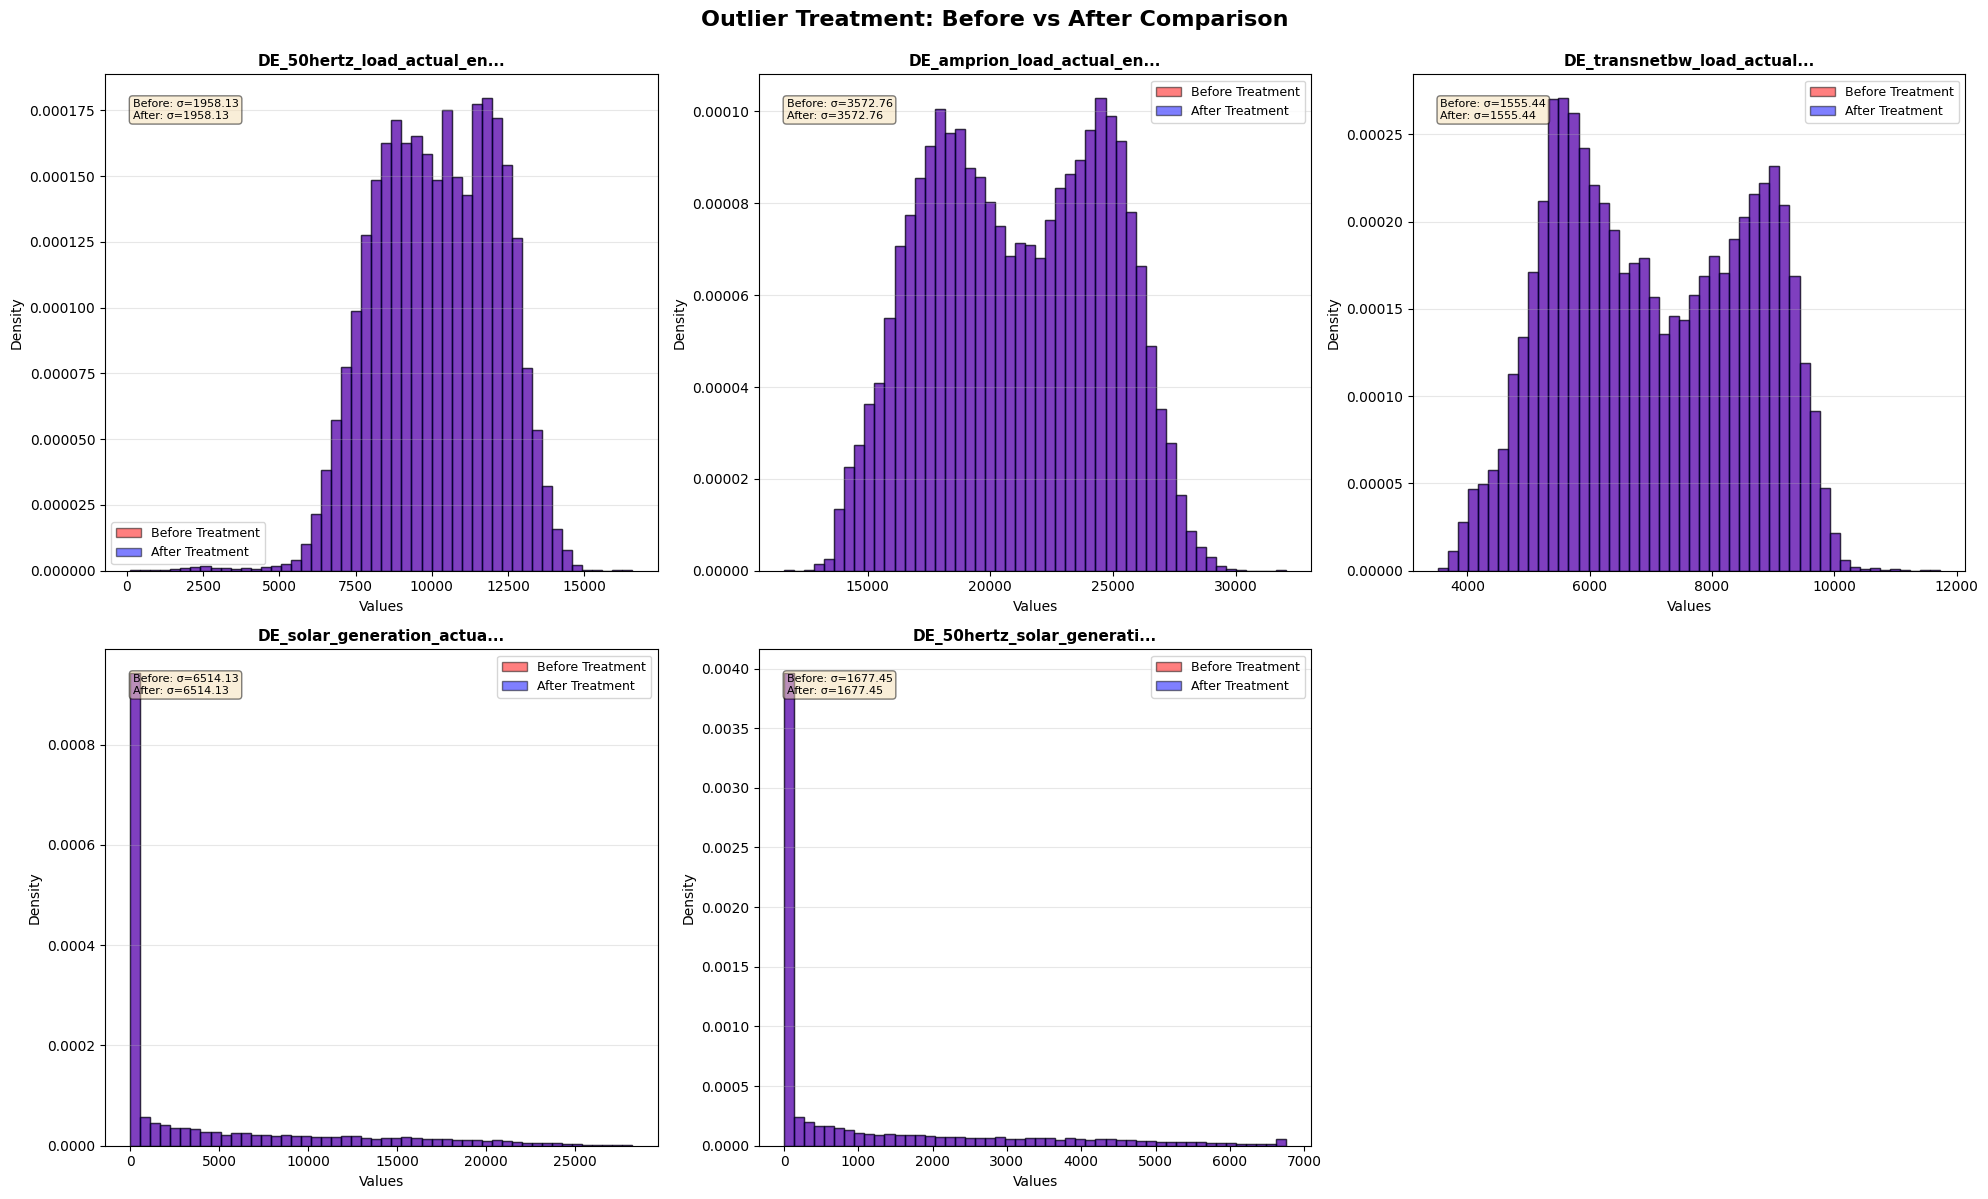


✓ Outlier treatment visualization complete


In [ ]:
# Outlier Treatment Visualization (Before/After Comparison)
print("="*80)
print("OUTLIER TREATMENT VISUALIZATION")
print("="*80)

# Compute outlier_report if it doesn't exist
try:
    _ = outlier_report
except NameError:
    print("Computing outlier report...")
    outlier_report = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col == 'target_load' or 'generation' in col.lower() or 'load' in col.lower():
            data = df[col].dropna()
            
            if len(data) == 0:
                continue
            
            # Method 1: IQR
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            outliers_iqr = data[(data < lower_bound) | (data > upper_bound)].index.tolist()
            
            # Method 2: Z-score
            z_scores = np.abs(scipy_stats.zscore(data))
            outliers_zscore = data[z_scores > 3].index.tolist()
            
            # Combine methods
            outliers = list(set(outliers_iqr + outliers_zscore))
            
            outlier_report[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(data) * 100 if len(data) > 0 else 0,
                'method': 'both'
            }

# Note: This assumes outlier treatment has been applied
# If df_before_outlier_treatment exists, use it; otherwise show current state
if 'df_before_outlier_treatment' not in locals():
    # Create a copy before treatment for comparison
    df_before_outlier_treatment = df.copy()

# Find columns that had outliers treated
treated_cols = [col for col in outlier_report.keys() if outlier_report[col]['count'] > 0][:5]

if len(treated_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(treated_cols[:6]):
        if col in df.columns and col in df_before_outlier_treatment.columns:
            ax = axes[idx]
            
            before_data = df_before_outlier_treatment[col].dropna()
            after_data = df[col].dropna()
            
            # Compare distributions
            ax.hist(before_data, bins=50, alpha=0.5, label='Before Treatment', color='red', edgecolor='black', density=True)
            ax.hist(after_data, bins=50, alpha=0.5, label='After Treatment', color='blue', edgecolor='black', density=True)
            ax.set_title(f'{col[:25]}...' if len(col) > 25 else col, fontsize=11, fontweight='bold')
            ax.set_xlabel('Values', fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add statistics text
            before_std = before_data.std()
            after_std = after_data.std()
            ax.text(0.05, 0.95, f'Before: σ={before_std:.2f}\nAfter: σ={after_std:.2f}', 
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide unused subplots
    for idx in range(len(treated_cols), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Outlier Treatment: Before vs After Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Outlier treatment visualization complete")
    print("="*80)
else:
    print("No outlier treatment data available for comparison")


## Step 7: Before vs After Gap-Filling for Load

Compare the target load variable before and after gap filling to understand the impact.

BEFORE VS AFTER GAP-FILLING FOR LOAD

BEFORE Gap Filling:
  Total timestamps: 32,856
  Non-null values: 32,856
  Missing values: 0
  Missing percentage: 0.00%
  Mean: 55,675.96 MW
  Std: 10,025.57 MW
  Min: 31,307.00 MW
  Max: 77,549.00 MW

AFTER Gap Filling:
  Total timestamps: 32,688
  Non-null values: 32,688
  Missing values: 0
  Missing percentage: 0.00%
  Mean: 55,697.94 MW
  Std: 10,025.70 MW
  Min: 31,307.00 MW
  Max: 77,549.00 MW

Changes:
  Timestamps added: -168
  Missing values change: 0


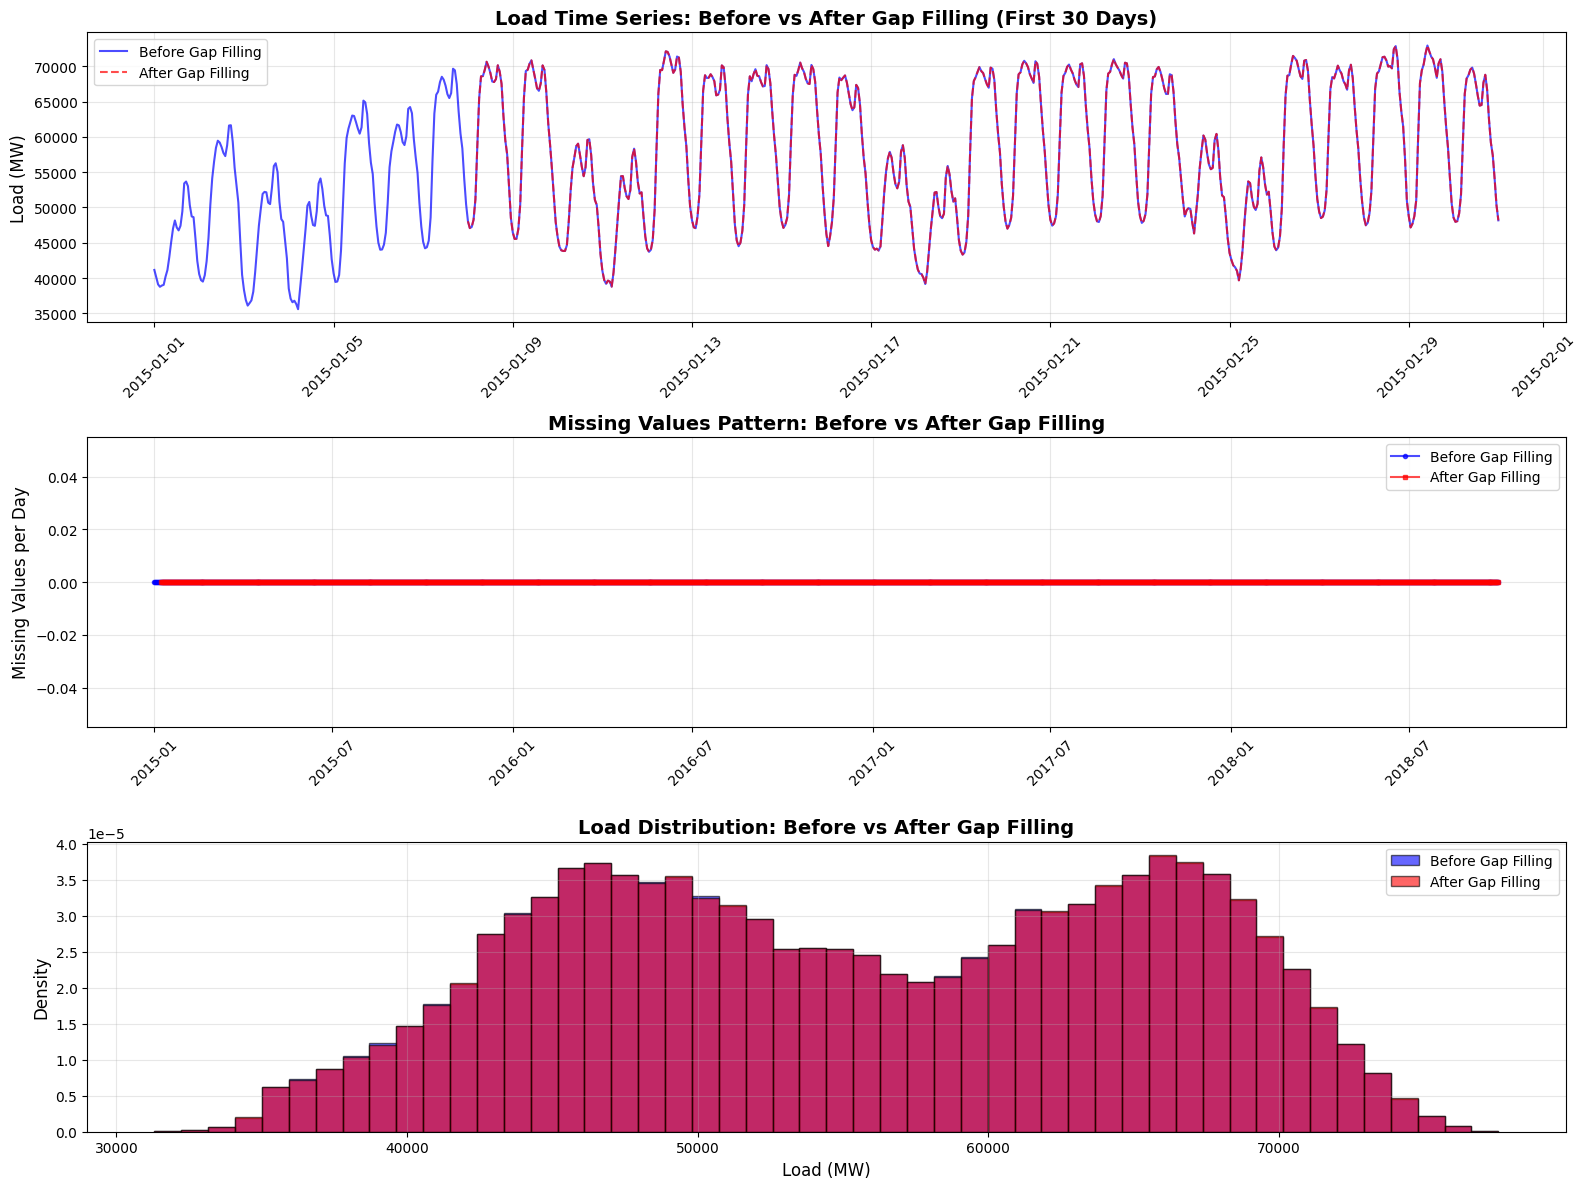


Visualization saved above.


In [ ]:
# Compare target_load before and after gap filling
if target_load_col and target_load_col in df_before_gap_fill.columns:
    print("="*80)
    print("BEFORE VS AFTER GAP-FILLING FOR LOAD")
    print("="*80)
    
    load_before = df_before_gap_fill[target_load_col].copy()
    load_after = df[target_load_col].copy()
    
    # Statistics before
    print(f"\nBEFORE Gap Filling:")
    print(f"  Total timestamps: {len(load_before):,}")
    print(f"  Non-null values: {load_before.notna().sum():,}")
    print(f"  Missing values: {load_before.isna().sum():,}")
    print(f"  Missing percentage: {(load_before.isna().sum() / len(load_before)) * 100:.2f}%")
    if load_before.notna().sum() > 0:
        print(f"  Mean: {load_before.mean():,.2f} MW")
        print(f"  Std: {load_before.std():,.2f} MW")
        print(f"  Min: {load_before.min():,.2f} MW")
        print(f"  Max: {load_before.max():,.2f} MW")
    
    # Statistics after
    print(f"\nAFTER Gap Filling:")
    print(f"  Total timestamps: {len(load_after):,}")
    print(f"  Non-null values: {load_after.notna().sum():,}")
    print(f"  Missing values: {load_after.isna().sum():,}")
    print(f"  Missing percentage: {(load_after.isna().sum() / len(load_after)) * 100:.2f}%")
    if load_after.notna().sum() > 0:
        print(f"  Mean: {load_after.mean():,.2f} MW")
        print(f"  Std: {load_after.std():,.2f} MW")
        print(f"  Min: {load_after.min():,.2f} MW")
        print(f"  Max: {load_after.max():,.2f} MW")
    
    # Calculate changes
    print(f"\nChanges:")
    print(f"  Timestamps added: {len(load_after) - len(load_before):,}")
    print(f"  Missing values change: {load_after.isna().sum() - load_before.isna().sum():,}")
    
    # Visualize before vs after
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Time series comparison (sample period)
    sample_start = load_before.index.min()
    sample_end = sample_start + pd.Timedelta(days=30)  # First 30 days
    
    load_before_sample = load_before[(load_before.index >= sample_start) & (load_before.index <= sample_end)]
    load_after_sample = load_after[(load_after.index >= sample_start) & (load_after.index <= sample_end)]
    
    axes[0].plot(load_before_sample.index, load_before_sample.values, 
                label='Before Gap Filling', linewidth=1.5, alpha=0.7, color='blue')
    axes[0].plot(load_after_sample.index, load_after_sample.values, 
                label='After Gap Filling', linewidth=1.5, alpha=0.7, color='red', linestyle='--')
    axes[0].set_ylabel('Load (MW)', fontsize=12)
    axes[0].set_title(f'Load Time Series: Before vs After Gap Filling (First 30 Days)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Missing values pattern
    missing_before_ts = load_before.isna().astype(int)
    missing_after_ts = load_after.isna().astype(int)
    
    # Resample to daily for visualization
    missing_before_daily = missing_before_ts.resample('D').sum()
    missing_after_daily = missing_after_ts.resample('D').sum()
    
    axes[1].plot(missing_before_daily.index, missing_before_daily.values, 
                label='Before Gap Filling', linewidth=1.5, alpha=0.7, color='blue', marker='o', markersize=3)
    axes[1].plot(missing_after_daily.index, missing_after_daily.values, 
                label='After Gap Filling', linewidth=1.5, alpha=0.7, color='red', marker='s', markersize=3)
    axes[1].set_ylabel('Missing Values per Day', fontsize=12)
    axes[1].set_title('Missing Values Pattern: Before vs After Gap Filling', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Distribution comparison
    if load_before.notna().sum() > 0 and load_after.notna().sum() > 0:
        axes[2].hist(load_before.dropna(), bins=50, alpha=0.6, label='Before Gap Filling', 
                    color='blue', edgecolor='black', density=True)
        axes[2].hist(load_after.dropna(), bins=50, alpha=0.6, label='After Gap Filling', 
                    color='red', edgecolor='black', density=True)
        axes[2].set_xlabel('Load (MW)', fontsize=12)
        axes[2].set_ylabel('Density', fontsize=12)
        axes[2].set_title('Load Distribution: Before vs After Gap Filling', fontsize=14, fontweight='bold')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization saved above.")
    print("="*80)
else:
    print("Warning: target_load column not found. Skipping before/after comparison.")


In [ ]:

# Create complete date range with resolution-specific frequency
full_range = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq=expected_freq
)

missing_timestamps = full_range.difference(df.index)

print(f"\nTimestamp Analysis:")
print(f"Expected timestamps: {len(full_range):,}")
print(f"Actual timestamps: {len(df):,}")
print(f"Missing timestamps: {len(missing_timestamps):,}")

if len(missing_timestamps) > 0:
    print(f"Missing percentage: {len(missing_timestamps)/len(full_range)*100:.2f}%")
    df = df.reindex(full_range)
    print(f"\nReindexed to fill {len(missing_timestamps)} missing timestamps")
else:
    print(f"\nNo missing timestamps - continuous time series")

print(f"\nDate range after gap filling:")
print(f"  Start: {df.index.min()}")
print(f"  End: {df.index.max()}")
print(f"  Total periods: {len(df):,}")



Timestamp Analysis:
Expected timestamps: 32,856
Actual timestamps: 32,856
Missing timestamps: 0

No missing timestamps - continuous time series

Date range after gap filling:
  Start: 2015-01-01 00:00:00+00:00
  End: 2018-09-30 23:00:00+00:00
  Total periods: 32,856


---

## Step 8: Missing Value Imputation Visualization

Apply advanced multi-step imputation strategy to handle missing values.Visualize the impact of missing value imputation on the dataset.


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"\nImputing missing values for {len(numeric_cols)} numeric columns...")

imputation_stats = {}

# Special handling for DE_LU: starts in Oct 2018, use DE national load as proxy before that
DE_LU_START_DATE = pd.Timestamp('2018-10-01')
if df.index.tz is not None:
    DE_LU_START_DATE = pd.Timestamp('2018-10-01', tz=df.index.tz)

de_lu_cols = [col for col in numeric_cols if 'DE_LU' in col and 'load' in col]
de_national_load_col = 'target_load' if 'target_load' in df.columns else None

for col in numeric_cols:
    missing_before = df[col].isnull().sum()
    
    if missing_before == 0:
        continue
    
    # Special handling for DE_LU load columns before Oct 2018
    if col in de_lu_cols and de_national_load_col and de_national_load_col in df.columns:
        print(f"  Special handling for {col}: Using DE national load as proxy before Oct 2018")
        # For DE_LU before Oct 2018, use DE national load scaled by time-varying ratio
        mask_before_2018 = df.index < DE_LU_START_DATE
        missing_before_2018 = df.loc[mask_before_2018, col].isnull().sum()
        
        if missing_before_2018 > 0:
            # Calculate time-varying ratio of DE_LU to DE national load (after Oct 2018)
            # Use hourly patterns to capture diurnal variations
            mask_after_2018 = df.index >= DE_LU_START_DATE
            if mask_after_2018.sum() > 0:
                de_lu_valid = df.loc[mask_after_2018, col].dropna()
                de_national_valid = df.loc[mask_after_2018, de_national_load_col].dropna()
                common_idx = de_lu_valid.index.intersection(de_national_valid.index)
                
                if len(common_idx) > 0:
                    # Calculate ratio for each hour of day to capture diurnal patterns
                    ratios_df = pd.DataFrame({
                        'de_lu': de_lu_valid.loc[common_idx],
                        'de_national': de_national_valid.loc[common_idx],
                        'hour': common_idx.hour
                    })
                    ratios_df['ratio'] = ratios_df['de_lu'] / ratios_df['de_national']
                    hourly_ratios = ratios_df.groupby('hour')['ratio'].mean()
                    
                    # Apply hourly ratios to missing values before 2018
                    mask_missing = mask_before_2018 & df[col].isnull()
                    missing_indices = df[mask_missing].index
                    
                    for idx in missing_indices:
                        hour = idx.hour
                        if hour in hourly_ratios.index:
                            ratio = hourly_ratios[hour]
                            df.loc[idx, col] = df.loc[idx, de_national_load_col] * ratio
                        else:
                            # Fallback to overall mean ratio if hour not found
                            overall_ratio = ratios_df['ratio'].mean()
                            df.loc[idx, col] = df.loc[idx, de_national_load_col] * overall_ratio
                    
                    print(f"    Imputed {missing_before_2018:,} values using hourly-varying DE national load proxy")
                    print(f"    Hourly ratios range: {hourly_ratios.min():.4f} to {hourly_ratios.max():.4f}")
    
    # Standard imputation for remaining missing values (or all if not DE_LU)
    remaining_missing = df[col].isnull().sum()
    if remaining_missing == 0:
        missing_after = 0
        imputation_stats[col] = {
            'before': int(missing_before),
            'after': int(missing_after),
            'imputed': int(missing_before - missing_after)
        }
        continue
    
    # Strategy 1: Forward fill for short gaps (< 6 periods)
    df[col] = df[col].fillna(method='ffill', limit=6)
    
    # Strategy 2: Backward fill for remaining
    df[col] = df[col].fillna(method='bfill', limit=6)
    
    # Strategy 3: Linear interpolation
    df[col] = df[col].interpolate(method='time', limit_direction='both')
    
    # Strategy 4: Seasonal mean (same hour of day, same day of week)
    remaining_missing = df[col].isnull().sum()
    if remaining_missing > 0:
        hour = df.index.hour
        dayofweek = df.index.dayofweek
        
        temp_df = df.copy()
        temp_df['_hour'] = hour
        temp_df['_dayofweek'] = dayofweek
        seasonal_means = temp_df.groupby(['_hour', '_dayofweek'])[col].mean()
        
        # Fill remaining with seasonal mean
        for idx in df[df[col].isnull()].index:
            h = idx.hour
            d = idx.dayofweek
            if (h, d) in seasonal_means.index:
                df.loc[idx, col] = seasonal_means.loc[(h, d)]
        
        # Strategy 5: Overall mean as final fallback (only if still missing)
        remaining_missing = df[col].isnull().sum()
        if remaining_missing > 0:
            col_mean = df[col].mean()
            if pd.notna(col_mean):
                df[col].fillna(col_mean, inplace=True)
            else:
                # If mean is NaN (all values were NaN), use 0 as last resort
                df[col].fillna(0, inplace=True)
    
    missing_after = df[col].isnull().sum()
    imputation_stats[col] = {
        'before': int(missing_before),
        'after': int(missing_after),
        'imputed': int(missing_before - missing_after)
    }

total_imputed = sum([v['imputed'] for v in imputation_stats.values()])
print(f"\nImputed {total_imputed:,} missing values")
print(f"Columns processed: {len(imputation_stats)}")

# Verify no missing values remain
remaining_missing = df[numeric_cols].isnull().sum().sum()
if remaining_missing > 0:
    print(f"  Warning: {remaining_missing} missing values still remain")
else:
    print(f"  All missing values successfully imputed!")


Imputing missing values for 26 numeric columns...

Imputed 164,624 missing values
Columns processed: 13
  All missing values successfully imputed!


MISSING VALUE IMPUTATION VISUALIZATION


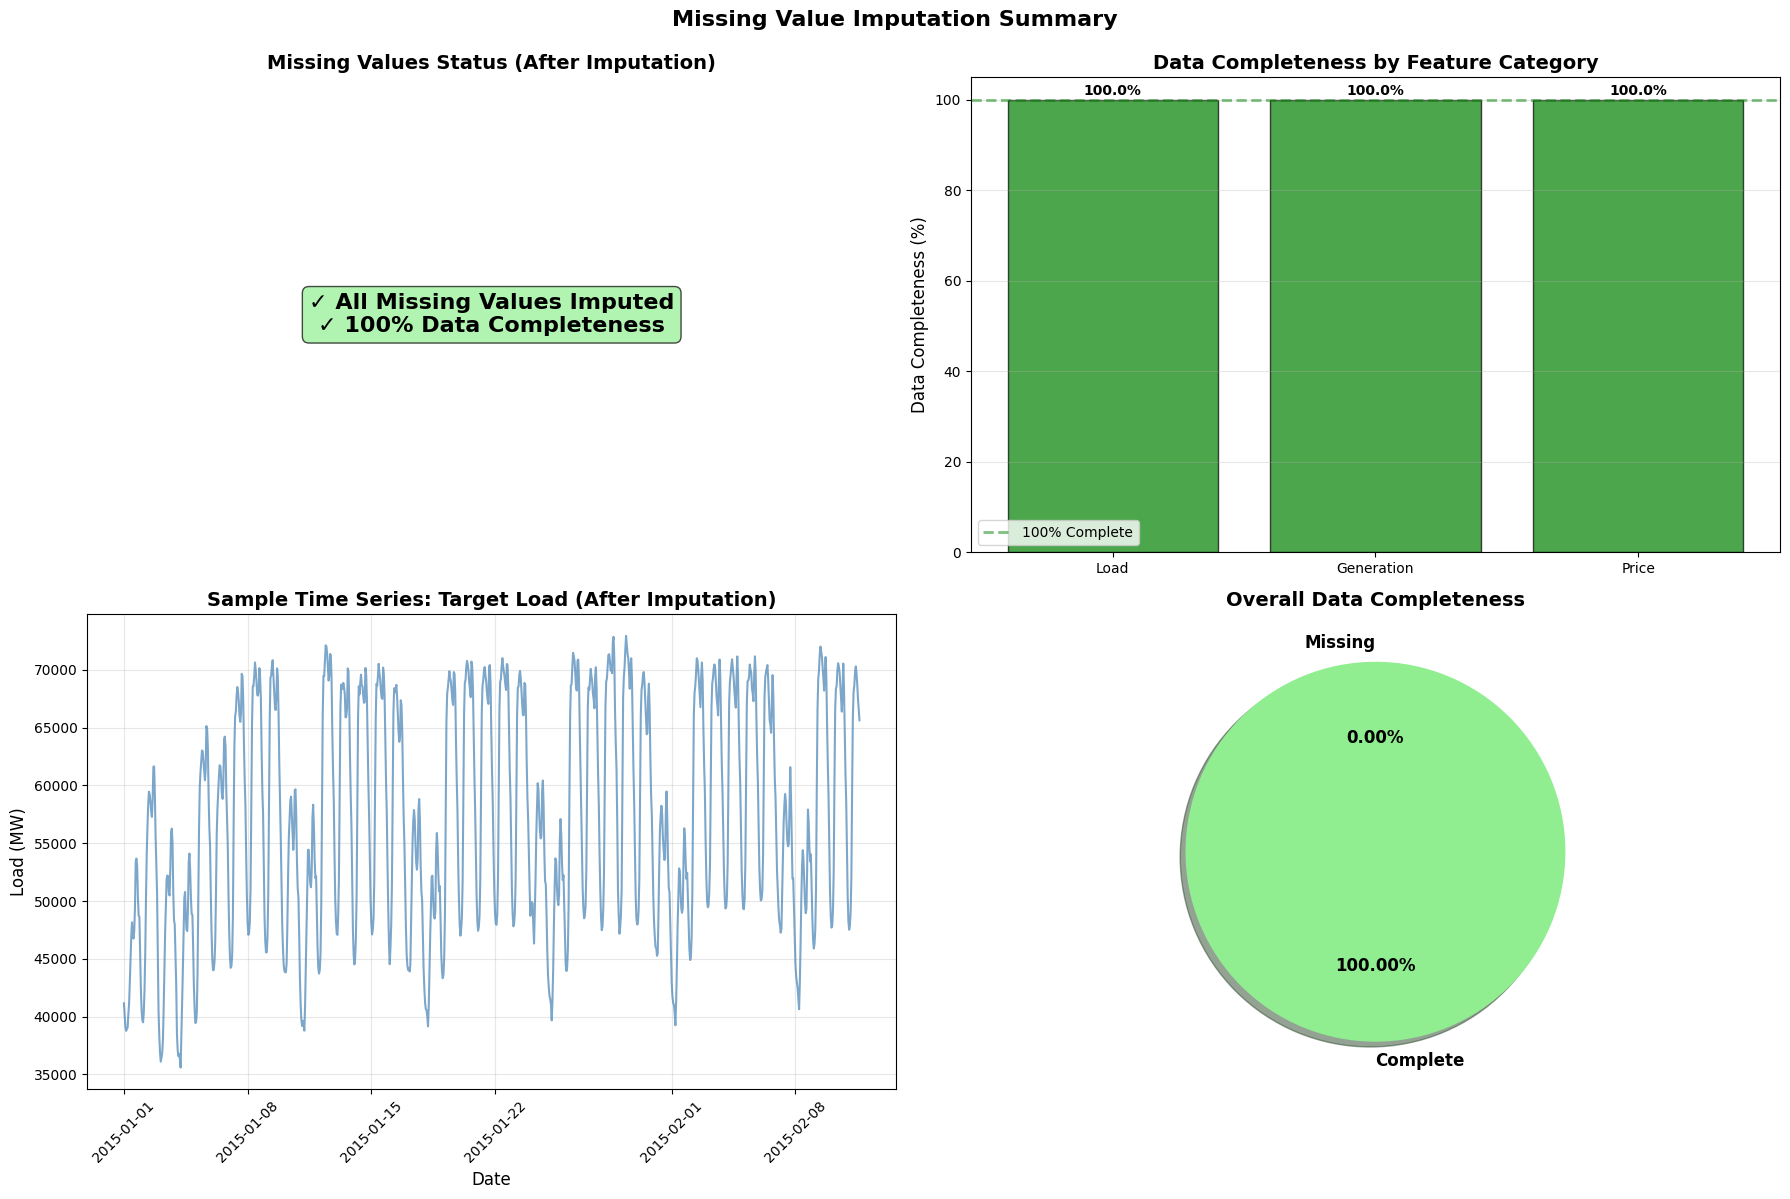


✓ Imputation visualization complete
  Total cells: 854,256
  Complete cells: 854,256 (100.00%)
  Missing cells: 0 (0.00%)


In [ ]:
# Missing Value Imputation Visualization
print("="*80)
print("MISSING VALUE IMPUTATION VISUALIZATION")
print("="*80)

# Check missing values before and after imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns
missing_after = df[numeric_cols].isnull().sum()
total_missing_after = missing_after.sum()

# Get columns that had missing values (if we tracked before imputation)
cols_with_missing = missing_after[missing_after > 0].index.tolist()[:10]

if len(cols_with_missing) > 0 or total_missing_after == 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Missing values status (after imputation)
    ax1 = axes[0, 0]
    if total_missing_after == 0:
        ax1.text(0.5, 0.5, '✓ All Missing Values Imputed\n✓ 100% Data Completeness', 
                ha='center', va='center', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                transform=ax1.transAxes)
        ax1.set_title('Missing Values Status (After Imputation)', fontsize=14, fontweight='bold')
        ax1.axis('off')
    else:
        missing_counts = missing_after[missing_after > 0].head(10)
        ax1.barh(range(len(missing_counts)), missing_counts.values, color='red', alpha=0.7, edgecolor='black')
        ax1.set_yticks(range(len(missing_counts)))
        ax1.set_yticklabels([col[:30] + '...' if len(col) > 30 else col for col in missing_counts.index], fontsize=9)
        ax1.set_xlabel('Remaining Missing Values', fontsize=12)
        ax1.set_title('Remaining Missing Values (After Imputation)', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        ax1.invert_yaxis()
    
    # 2. Data completeness by feature type
    ax2 = axes[0, 1]
    load_cols = [col for col in numeric_cols if 'load' in col.lower()]
    gen_cols = [col for col in numeric_cols if 'generation' in col.lower()]
    price_cols = [col for col in numeric_cols if 'price' in col.lower()]
    weather_cols = [col for col in numeric_cols if any(x in col for x in ['temperature', 'wind_speed', 'humidity', 'precipitation', 'cloud_cover', 'solar_radiation', 'air_density'])]
    
    categories = []
    completeness = []
    if load_cols:
        categories.append('Load')
        completeness.append((1 - df[load_cols].isnull().sum().sum() / (len(df) * len(load_cols))) * 100)
    if gen_cols:
        categories.append('Generation')
        completeness.append((1 - df[gen_cols].isnull().sum().sum() / (len(df) * len(gen_cols))) * 100)
    if price_cols:
        categories.append('Price')
        completeness.append((1 - df[price_cols].isnull().sum().sum() / (len(df) * len(price_cols))) * 100)
    if weather_cols:
        categories.append('Weather')
        completeness.append((1 - df[weather_cols].isnull().sum().sum() / (len(df) * len(weather_cols))) * 100)
    
    if categories:
        colors = ['green' if c == 100 else 'orange' if c >= 95 else 'red' for c in completeness]
        ax2.bar(categories, completeness, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_ylim([0, 105])
        ax2.set_ylabel('Data Completeness (%)', fontsize=12)
        ax2.set_title('Data Completeness by Feature Category', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(completeness):
            ax2.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
        ax2.axhline(y=100, color='green', linestyle='--', linewidth=2, alpha=0.5, label='100% Complete')
        ax2.legend()
    
    # 3. Sample time series showing imputation (if target_load exists)
    ax3 = axes[1, 0]
    if 'target_load' in df.columns:
        sample_period = df['target_load'].iloc[:1000]  # First 1000 points
        ax3.plot(sample_period.index, sample_period.values, linewidth=1.5, alpha=0.7, color='steelblue')
        ax3.set_title('Sample Time Series: Target Load (After Imputation)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Date', fontsize=12)
        ax3.set_ylabel('Load (MW)', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
    else:
        ax3.text(0.5, 0.5, 'Target load column not available', ha='center', va='center',
                transform=ax3.transAxes, fontsize=12)
        ax3.axis('off')
    
    # 4. Overall imputation summary
    ax4 = axes[1, 1]
    total_cells = len(df) * len(numeric_cols)
    imputed_cells = total_missing_after
    complete_cells = total_cells - imputed_cells
    
    if total_cells > 0:
        labels = ['Complete', 'Missing']
        sizes = [complete_cells, imputed_cells]
        colors_pie = ['lightgreen', 'lightcoral']
        explode = (0, 0.1) if imputed_cells > 0 else (0, 0)
        
        ax4.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.2f%%',
               shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax4.set_title('Overall Data Completeness', fontsize=14, fontweight='bold')
    
    plt.suptitle('Missing Value Imputation Summary', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Imputation visualization complete")
    print(f"  Total cells: {total_cells:,}")
    print(f"  Complete cells: {complete_cells:,} ({100*(1-imputed_cells/total_cells):.2f}%)")
    print(f"  Missing cells: {imputed_cells:,} ({100*imputed_cells/total_cells:.2f}%)")
    print("="*80)
else:
    print("No missing value data available for visualization")


## Feature Engineering

---

## Step 12: Calendar Feature Engineering

Create comprehensive calendar features to capture temporal patterns.


In [ ]:

# Basic time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0=Monday, 6=Sunday
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

# Cyclical encoding for periodic features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Weekend indicator
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Holiday detection
try:
    if target_country == 'DE' or target_country.startswith('DE'):
        # Get holidays for the years in our dataset (2015-2018)
        de_holidays = holidays.Germany(years=range(2015, 2019))
    elif target_country == 'GB_GBN' or target_country.startswith('GB'):
        de_holidays = holidays.UnitedKingdom(years=range(2015, 2019))
    else:
        de_holidays = {}
    
    # Fix: de_holidays.keys() already returns date objects, convert to list for isin()
    holiday_dates = list(de_holidays.keys())
    df['is_holiday'] = df.index.date.isin(holiday_dates).astype(int)
    
    # Debug: Check if holidays were detected
    holiday_count = df['is_holiday'].sum()
    print(f"Holidays detected: {holiday_count} rows ({holiday_count/len(df)*100:.2f}%)")
except Exception as e:
    print(f"Warning: Holiday detection failed: {e}")
    df['is_holiday'] = 0

# Special day indicators
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)

# Time of day categories
df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)
df['time_of_day'] = df['time_of_day'].astype(str)

# Season
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Days since start (for trend)
df['days_since_start'] = (df.index - df.index.min()).days

calendar_feature_cols = [c for c in df.columns if 'hour' in c or 'day' in c or 'month' in c or 'is_' in c or 'time_of_day' in c or 'season' in c or 'quarter' in c or 'week' in c or 'year' in c or 'days_since' in c]

print(f"\nCreated {len(calendar_feature_cols)} calendar features")
print(f"Basic: hour, day_of_week, month, quarter, year")
print(f"Cyclical: sin/cos encodings for hour, day_of_week, month")
print(f"Special: is_weekend, is_holiday, time_of_day, season")
print(f"\nCalendar features: {calendar_feature_cols[:10]}...")



Created 21 calendar features
Basic: hour, day_of_week, month, quarter, year
Cyclical: sin/cos encodings for hour, day_of_week, month
Special: is_weekend, is_holiday, time_of_day, season

Calendar features: ['DE_LU_price_day_ahead', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'hour_sin', 'hour_cos']...


---

## Step 9: Calendar Feature Visualization

Visualize the engineered calendar features to understand temporal patterns.


CALENDAR FEATURE VISUALIZATION


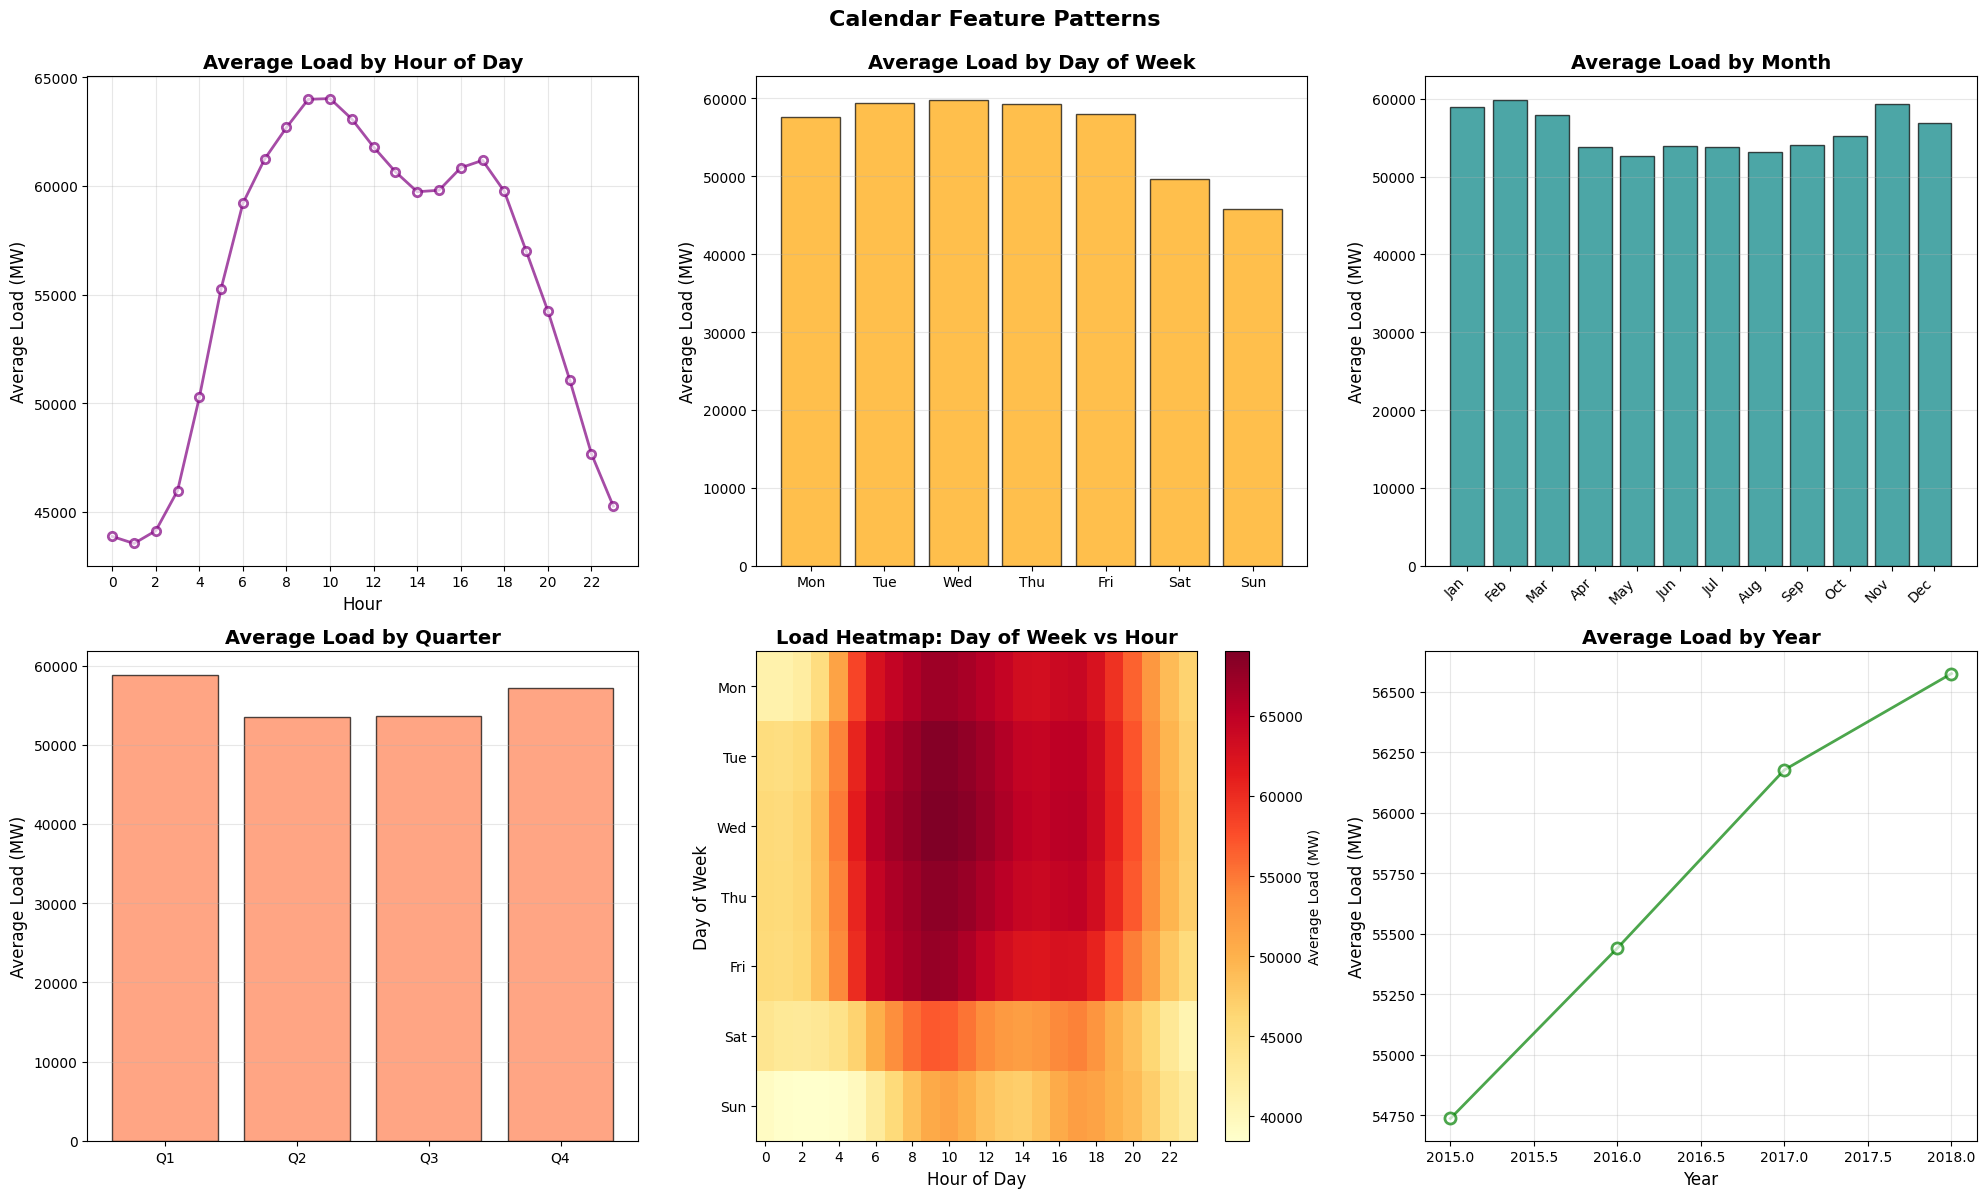


✓ Calendar feature visualization complete (6 features)


In [ ]:
# Calendar Feature Visualization
print("="*80)
print("CALENDAR FEATURE VISUALIZATION")
print("="*80)

# Check if calendar features exist
calendar_features = ['hour', 'day_of_week', 'month', 'quarter', 'day_of_month', 'week_of_year']
available_calendar = [f for f in calendar_features if f in df.columns]

if len(available_calendar) > 0 and 'target_load' in df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # 1. Hourly pattern
    if 'hour' in df.columns:
        ax = axes[0]
        hourly_avg = df.groupby('hour')['target_load'].mean()
        ax.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6, 
               color='purple', alpha=0.7, markerfacecolor='white', markeredgewidth=2)
        ax.set_title('Average Load by Hour of Day', fontsize=14, fontweight='bold')
        ax.set_xlabel('Hour', fontsize=12)
        ax.set_ylabel('Average Load (MW)', fontsize=12)
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)
    
    # 2. Day of week pattern
    if 'day_of_week' in df.columns:
        ax = axes[1]
        dow_avg = df.groupby('day_of_week')['target_load'].mean()
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        ax.bar(range(7), dow_avg.values, color='orange', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(7))
        ax.set_xticklabels(day_names)
        ax.set_title('Average Load by Day of Week', fontsize=14, fontweight='bold')
        ax.set_ylabel('Average Load (MW)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Monthly pattern
    if 'month' in df.columns:
        ax = axes[2]
        monthly_avg = df.groupby('month')['target_load'].mean()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax.bar(range(1, 13), monthly_avg.values, color='teal', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(month_names, rotation=45, ha='right')
        ax.set_title('Average Load by Month', fontsize=14, fontweight='bold')
        ax.set_ylabel('Average Load (MW)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Quarterly pattern
    if 'quarter' in df.columns:
        ax = axes[3]
        quarterly_avg = df.groupby('quarter')['target_load'].mean()
        quarter_names = ['Q1', 'Q2', 'Q3', 'Q4']
        ax.bar(range(1, 5), quarterly_avg.values, color='coral', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(1, 5))
        ax.set_xticklabels(quarter_names)
        ax.set_title('Average Load by Quarter', fontsize=14, fontweight='bold')
        ax.set_ylabel('Average Load (MW)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
    
    # 5. Heatmap: Hour vs Day of Week
    if 'hour' in df.columns and 'day_of_week' in df.columns:
        ax = axes[4]
        heatmap_data = df.groupby(['day_of_week', 'hour'])['target_load'].mean().unstack()
        im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
        ax.set_title('Load Heatmap: Day of Week vs Hour', fontsize=14, fontweight='bold')
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Day of Week', fontsize=12)
        ax.set_xticks(range(0, 24, 2))
        ax.set_yticks(range(7))
        ax.set_yticklabels(day_names)
        plt.colorbar(im, ax=ax, label='Average Load (MW)')
    
    # 6. Yearly trend
    if 'year' in df.columns or df.index.year.nunique() > 1:
        ax = axes[5]
        if 'year' in df.columns:
            yearly_avg = df.groupby('year')['target_load'].mean()
        else:
            yearly_avg = df.groupby(df.index.year)['target_load'].mean()
        ax.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=8, 
               color='green', alpha=0.7, markerfacecolor='white', markeredgewidth=2)
        ax.set_title('Average Load by Year', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Average Load (MW)', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Calendar Feature Patterns', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Calendar feature visualization complete ({len(available_calendar)} features)")
    print("="*80)
else:
    print("Calendar features or target_load not available for visualization")


---

## Step 13: Lagged Feature Engineering

Create lagged features to capture temporal dependencies and patterns.


In [ ]:

lagged_features = []

# Lagged target variable
for lag in LAGS:
    col_name = f'target_load_lag_{lag}'
    df[col_name] = df['target_load'].shift(lag)
    lagged_features.append(col_name)

# Rolling statistics
for window in [3, 6, 12, 24]:
    df[f'target_load_rolling_mean_{window}'] = df['target_load'].rolling(window=window).mean()
    df[f'target_load_rolling_std_{window}'] = df['target_load'].rolling(window=window).std()
    lagged_features.extend([f'target_load_rolling_mean_{window}', f'target_load_rolling_std_{window}'])

# Exponential moving averages
for span in [6, 12, 24]:
    df[f'target_load_ema_{span}'] = df['target_load'].ewm(span=span).mean()
    lagged_features.append(f'target_load_ema_{span}')

# Same period previous week (weekly seasonality)
if expected_freq == '15T':
    weekly_lag = 672  # 7 days * 24 hours * 4
elif expected_freq == '30T':
    weekly_lag = 336  # 7 days * 24 hours * 2
else:  # 1H
    weekly_lag = 168  # 7 days * 24 hours

df['target_load_same_hour_last_week'] = df['target_load'].shift(weekly_lag)
lagged_features.append('target_load_same_hour_last_week')

# Lagged generation features (if available)
generation_cols = [col for col in df.columns if 'generation' in col.lower()]
for col in generation_cols[:3]:  # Limit to first 3
    for lag in [1, 6, 24]:
        lag_name = f'{col}_lag_{lag}'
        df[lag_name] = df[col].shift(lag)
        lagged_features.append(lag_name)

print(f"\nCreated {len(lagged_features)} lagged features")
print(f"Lagged target: {len(LAGS)} lags")
print(f"Rolling statistics: mean and std for multiple windows")
print(f"EMA: exponential moving averages")
print(f"Weekly seasonality: same period last week (lag={weekly_lag})")
print(f"\nSample lagged features: {lagged_features[:10]}...")



Created 29 lagged features
Lagged target: 8 lags
Rolling statistics: mean and std for multiple windows
EMA: exponential moving averages
Weekly seasonality: same period last week (lag=168)

Sample lagged features: ['target_load_lag_1', 'target_load_lag_2', 'target_load_lag_3', 'target_load_lag_6', 'target_load_lag_12', 'target_load_lag_24', 'target_load_lag_48', 'target_load_lag_168', 'target_load_rolling_mean_3', 'target_load_rolling_std_3']...


---

## Step 14: Weather Proxy Feature Engineering

Create weather proxy features from generation data.


In [ ]:

weather_features = []

# Solar generation as proxy for solar radiation/cloud cover
solar_cols = [col for col in df.columns if 'solar' in col.lower() and 'generation' in col.lower()]
if solar_cols:
    solar_col = solar_cols[0]
    # Normalize solar by capacity if available
    capacity_col = [col for col in df.columns if 'solar_capacity' in col.lower()]
    if capacity_col:
        df['solar_normalized'] = df[solar_col] / (df[capacity_col[0]] + 1e-6)
        weather_features.append('solar_normalized')
    else:
        df['solar_proxy'] = df[solar_col]
        weather_features.append('solar_proxy')

# Wind generation as proxy for wind speed
wind_cols = [col for col in df.columns if 'wind' in col.lower() and 'generation' in col.lower() and 'onshore' in col.lower()]
if wind_cols:
    wind_col = wind_cols[0]
    capacity_col = [col for col in df.columns if 'wind' in col.lower() and 'capacity' in col.lower() and 'onshore' in col.lower()]
    if capacity_col:
        df['wind_normalized'] = df[wind_col] / (df[capacity_col[0]] + 1e-6)
        weather_features.append('wind_normalized')
    else:
        df['wind_proxy'] = df[wind_col]
        weather_features.append('wind_proxy')

# Temperature proxy
if 'solar_proxy' in df.columns or 'solar_normalized' in df.columns:
    solar_feat = 'solar_normalized' if 'solar_normalized' in df.columns else 'solar_proxy'
    df['temp_proxy'] = df[solar_feat] * df['month'] / 12
    weather_features.append('temp_proxy')

print(f"\nCreated {len(weather_features)} weather proxy features")
print(f"Solar radiation proxy: from solar generation")
print(f"Wind speed proxy: from wind generation")
print(f"Temperature proxy: derived from solar and season")
print(f"\nWeather features: {weather_features}")



Created 3 weather proxy features
Solar radiation proxy: from solar generation
Wind speed proxy: from wind generation
Temperature proxy: derived from solar and season

Weather features: ['solar_proxy', 'wind_proxy', 'temp_proxy']


---

## Step 15: Categorical Feature Encoding

Encode categorical features using one-hot encoding.


In [ ]:

# One-hot encode categorical features
categorical_cols = ['time_of_day', 'season']

for col in categorical_cols:
    if col in df.columns:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)

print(f"\nEncoded {len(categorical_cols)} categorical features")
print(f"Method: One-hot encoding with drop_first=True")
print(f"Features encoded: {categorical_cols}")



Encoded 2 categorical features
Method: One-hot encoding with drop_first=True
Features encoded: ['time_of_day', 'season']


---

## Step 16: Infinite Value Handling

Check and handle infinite values in the dataset.


In [ ]:

numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_count = 0

for col in numeric_cols:
    inf_mask = np.isinf(df[col])
    inf_count += inf_mask.sum()
    if inf_mask.sum() > 0:
        # Replace inf with NaN, then fill with median
        df.loc[inf_mask, col] = np.nan
        df[col].fillna(df[col].median(), inplace=True)

print(f"\nHandled {inf_count} infinite values")
if inf_count == 0:
    print(f"No infinite values detected")



Handled 0 infinite values
No infinite values detected


---

## Step 17: Feature Normalization

Normalize features using RobustScaler (robust to outliers).


In [ ]:

# Don't scale target variable
exclude_cols = ['target_load']
numeric_cols = df.select_dtypes(include=[np.number]).columns
cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nScaling {len(cols_to_scale)} features using RobustScaler...")

# Store original values for target
df_scaled = df.copy()

# Fit and transform
scaler = RobustScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print(f"Normalized {len(cols_to_scale)} features")
print(f"Method: RobustScaler")
print(f"Target variable preserved in original scale")

# Update df to scaled version
df = df_scaled.copy()



Scaling 75 features using RobustScaler...
Normalized 75 features
Method: RobustScaler
Target variable preserved in original scale


---

## Step 10: Feature Normalization Visualization

Compare feature distributions before and after normalization.


FEATURE NORMALIZATION VISUALIZATION
Note: Showing current normalized state (before/after comparison requires df_before_normalization)


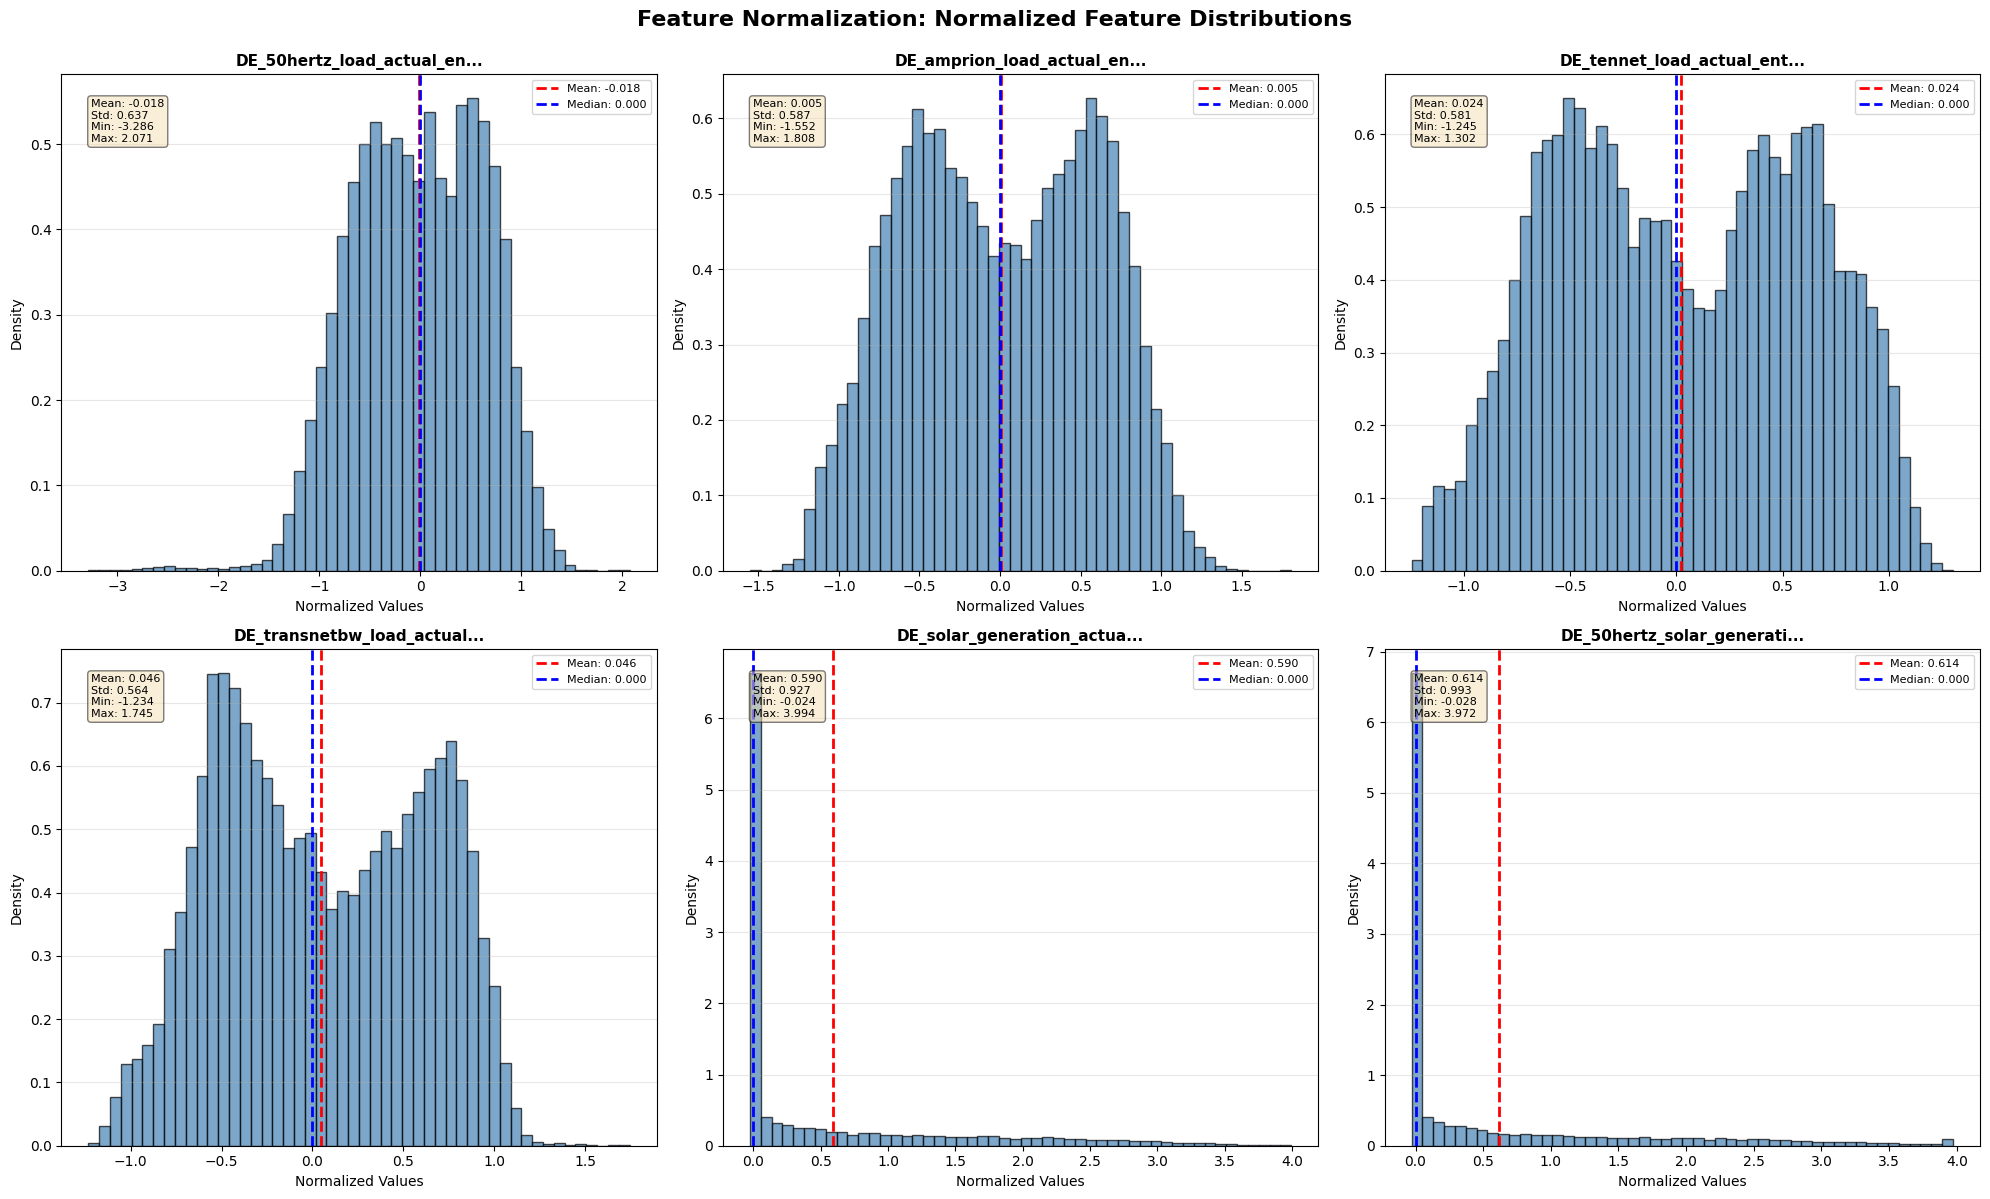


Normalization Summary:
  Features normalized: 6
  DE_50hertz_load_actual_entsoe_: mean=-0.018, std=0.637, range=[-3.286, 2.071]
  DE_amprion_load_actual_entsoe_: mean=0.005, std=0.587, range=[-1.552, 1.808]
  DE_tennet_load_actual_entsoe_t: mean=0.024, std=0.581, range=[-1.245, 1.302]
  DE_transnetbw_load_actual_ents: mean=0.046, std=0.564, range=[-1.234, 1.745]
  DE_solar_generation_actual: mean=0.590, std=0.927, range=[-0.024, 3.994]

✓ Normalization visualization complete


In [ ]:
# Feature Normalization Visualization
print("="*80)
print("FEATURE NORMALIZATION VISUALIZATION")
print("="*80)

# Note: This assumes normalization has been applied
# If df_before_normalization exists, use it; otherwise show current state
if 'df_before_normalization' not in locals():
    # For demonstration, show current normalized state
    print("Note: Showing current normalized state (before/after comparison requires df_before_normalization)")

numeric_cols = df.select_dtypes(include=[np.number]).columns
# Exclude target_load from normalization visualization
feature_cols = [col for col in numeric_cols if col != 'target_load'][:6]

if len(feature_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(feature_cols):
        ax = axes[idx]
        data = df[col].dropna()
        
        if len(data) > 0:
            # Show distribution
            ax.hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='black', density=True)
            ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.3f}')
            ax.axvline(data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {data.median():.3f}')
            ax.set_title(f'{col[:25]}...' if len(col) > 25 else col, fontsize=11, fontweight='bold')
            ax.set_xlabel('Normalized Values', fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add statistics
            stats_text = f'Mean: {data.mean():.3f}\nStd: {data.std():.3f}\nMin: {data.min():.3f}\nMax: {data.max():.3f}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=8, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Feature Normalization: Normalized Feature Distributions', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nNormalization Summary:")
    print(f"  Features normalized: {len(feature_cols)}")
    for col in feature_cols[:5]:
        data = df[col].dropna()
        print(f"  {col[:30]}: mean={data.mean():.3f}, std={data.std():.3f}, range=[{data.min():.3f}, {data.max():.3f}]")
    
    print(f"\n✓ Normalization visualization complete")
    print("="*80)
else:
    print("No features available for normalization visualization")


---

## Step 18: Final Dataset Creation

Create final clean dataset by removing rows with NaN values.


In [ ]:

# Remove rows with any remaining NaN (from lagged features)
initial_rows = len(df)
df = df.dropna()
removed_rows = initial_rows - len(df)

print(f"\nRemoved {removed_rows} rows with NaN values")
print(f"Final dataset shape: {df.shape}")

# Remove timestamp column if present (keep as index)
if 'cet_cest_timestamp' in df.columns:
    df.drop('cet_cest_timestamp', axis=1, inplace=True)

# Final validation
print(f"\nFinal Dataset Statistics:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total features: {len(df.columns)}")

print(f"\nFirst few rows of processed data:")
df.head()



Removed 168 rows with NaN values
Final dataset shape: (32688, 83)

Final Dataset Statistics:
Shape: (32688, 82)
Missing values: 0
Infinite values: 0
Date range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
Total features: 82

First few rows of processed data:


,target_load,DE_50hertz_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,DE_tennet_load_actual_entsoe_transparency,DE_transnetbw_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_50hertz_solar_generation_actual,DE_LU_solar_generation_actual,DE_amprion_solar_generation_actual,DE_tennet_solar_generation_actual,DE_transnetbw_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,DE_50hertz_wind_generation_actual,DE_50hertz_wind_offshore_generation_actual,DE_50hertz_wind_onshore_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_wind_onshore_generation_actual,DE_amprion_wind_onshore_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_wind_onshore_generation_actual,DE_LU_price_day_ahead,hour,day_of_week,day_of_month,week_of_year,month,quarter,year,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,is_weekend,is_holiday,is_monday,is_friday,days_since_start,target_load_lag_1,target_load_lag_2,target_load_lag_3,target_load_lag_6,target_load_lag_12,target_load_lag_24,target_load_lag_48,target_load_lag_168,target_load_rolling_mean_3,target_load_rolling_std_3,target_load_rolling_mean_6,target_load_rolling_std_6,target_load_rolling_mean_12,target_load_rolling_std_12,target_load_rolling_mean_24,target_load_rolling_std_24,target_load_ema_6,target_load_ema_12,target_load_ema_24,target_load_same_hour_last_week,DE_solar_generation_actual_lag_1,DE_solar_generation_actual_lag_6,DE_solar_generation_actual_lag_24,DE_50hertz_solar_generation_actual_lag_1,DE_50hertz_solar_generation_actual_lag_6,DE_50hertz_solar_generation_actual_lag_24,DE_LU_solar_generation_actual_lag_1,DE_LU_solar_generation_actual_lag_6,DE_LU_solar_generation_actual_lag_24,solar_proxy,wind_proxy,temp_proxy,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,season_Spring,season_Summer,season_Winter
utc_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08 00:00:00+00:00,48041.0,-1.122114,-0.259727,-0.282854,-0.281882,-0.024428,-0.028402,0.0,-0.021525,-0.022444,-0.018476,0.783351,-0.332193,1.026565,0.788063,-0.235537,0.843578,0.0,0.0,0.0,0.993015,0.658223,-0.312107,1.147066,-0.052174,0.0,-1.000000,0.0,-0.533333,-0.958333,-0.833333,-0.5,-0.5,-4.329780e-17,0.707107,0.277479,-0.445042,0.366025,0.633975,0.0,0.0,0.0,0.0,-0.989766,-0.277664,-0.071957,0.171887,0.691935,0.678970,-0.583551,-0.590436,-0.808482,-0.253695,0.801163,0.046716,0.974818,0.495310,0.353456,0.366317,0.230953,-0.039416,0.205318,0.349626,-0.808482,-0.024494,-0.024481,-0.024439,-0.028402,-0.028402,-0.028402,0.0,0.0,0.0,-0.024428,1.026565,-0.018225,False,False,True,False,False,True
2015-01-08 01:00:00+00:00,47074.0,-1.110732,-0.327697,-0.363644,-0.330826,-0.024428,-0.028402,0.0,-0.021525,-0.022444,-0.018476,0.846004,-0.332682,1.100475,0.802356,-0.235537,0.858397,0.0,0.0,0.0,1.149010,0.710667,-0.312631,1.223055,0.060870,0.0,-0.913043,0.0,-0.533333,-0.958333,-0.833333,-0.5,-0.5,1.830127e-01,0.683013,0.277479,-0.445042,0.366025,0.633975,0.0,0.0,0.0,0.0,-0.989766,-0.415640,-0.277875,-0.072166,0.471652,0.610286,-0.635348,-0.647238,-0.866432,-0.389929,0.131162,-0.125358,0.820956,0.366641,0.577459,0.379611,0.138507,-0.189767,0.054041,0.238869,-0.866432,-0.024494,-0.024481,-0.024439,-0.028402,-0.028402,-0.028402,0.0,0.0,0.0,-0.024428,1.100475,-0.018225,False,False,True,False,False,True
2015-01-08 02:00:00+00:00,47228.0,-1.064228,-0.326219,-0.358662,-0.339527,-0.024428,-0.028402,0.0,-0.021525,-0.022444,-0.018476,0.870011,-0.333659,1.129141,0.838086,-0.227273,0.894896,0.0,0.0,0.0,1.285215,0.684624,-0.314727,1.186612,0.165217,0.0,-0.826087,0.0,-0.533333,-0.958333,-0.833333,-0.5,-0.5,3.535534e-01,0.612372,0.277479,-0.445042,0.366025,0.633975,0.0,0.0,0.0,0.0,-0.989766,-0.470796,-0.415857,-0.278111,0.292779,0.579024,-0.626735,-

---

## Step 19: Class Imbalance Handling - Cost-Sensitive Learning

Handle class imbalance in the dataset using Cost-Sensitive Learning (Class Weights). This method preserves temporal structure in time series data, unlike resampling methods that can break temporal dependencies.


In [ ]:
# ============================================================================
# STEP 16: CLASS IMBALANCE HANDLING - COST-SENSITIVE LEARNING
# ============================================================================

print("\nUsing Cost-Sensitive Learning (Class Weights) instead of resampling")
print("This preserves temporal structure in time series data")

# Import required libraries
try:
    from collections import Counter
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    COST_SENSITIVE_AVAILABLE = True
except ImportError as e:
    print(f"\nWarning: Required libraries not available: {e}")
    COST_SENSITIVE_AVAILABLE = False

if COST_SENSITIVE_AVAILABLE:
    print("\nLibraries loaded successfully")
    
    # Identify control region load columns (including DE_LU as it's both bidding zone and control region)
    control_region_load_cols = [
        'DE_50hertz_load_actual_entsoe_transparency',
        'DE_amprion_load_actual_entsoe_transparency',
        'DE_tennet_load_actual_entsoe_transparency',
        'DE_transnetbw_load_actual_entsoe_transparency',
        'DE_LU_load_actual_entsoe_transparency'  # Bidding zone AND control region (starts Oct 2018)
    ]
    
    # Check for control region load columns (including DE_LU)
    existing_control_cols = [col for col in control_region_load_cols if col in df.columns]
    
    # If load columns not found, check for generation columns from control regions
    if len(existing_control_cols) == 0:
        print("\nControl region load columns not found. Checking for generation columns...")
        control_region_prefixes = ['DE_50hertz_', 'DE_amprion_', 'DE_tennet_', 'DE_transnetbw_', 'DE_LU_']
        existing_control_cols = [col for col in df.columns 
                                 if any(col.startswith(prefix) for prefix in control_region_prefixes)
                                 and df[col].dtype in [np.float64, np.int64]]
        if len(existing_control_cols) > 0:
            print(f"Found {len(existing_control_cols)} control region generation columns")
    else:
        print(f"Found {len(existing_control_cols)} control region load columns (including DE_LU)")
    
    print(f"\nTotal control region columns found: {len(existing_control_cols)}")
    
                # Analyze temporal coverage - all 4 control regions available throughout 2015-2018
    if len(existing_control_cols) > 0:
        print("\nAnalyzing temporal coverage of control regions...")
        print("  Note: Dataset covers 2015-2018, all 4 control regions available throughout")
        
        for col in existing_control_cols:
            first_valid = df[col].first_valid_index()
            last_valid = df[col].last_valid_index()
            coverage_pct = (df[col].notna().sum() / len(df)) * 100
            region_name = col.replace('_load_actual_entsoe_transparency', '').replace('DE_', '')
            print(f"  {region_name}: {coverage_pct:.1f}% coverage, starts: {first_valid}, ends: {last_valid}")
    
    if len(existing_control_cols) > 0:
        # Analyze temporal coverage - all 4 control regions available throughout 2015-2018
        print("\nAnalyzing temporal coverage patterns in control regions...")
        print("  Note: Dataset covers 2015-2018, all 4 control regions available throughout")
        print("  No temporal imbalance - DE_LU excluded (starts Oct 2018)")
        
        # All 4 control regions are available throughout the dataset period
        # Create classification target based on load levels
        print("\nCreating classification target based on load levels...")
        
        # Use median split of main load column
        main_load_col = 'target_load' if 'target_load' in df.columns else 'DE_load_actual_entsoe_transparency'
        if main_load_col in df.columns:
            median_load = df[main_load_col].median()
            df['control_regions_complete'] = (df[main_load_col] >= median_load).astype(int)
            target_col = 'control_regions_complete'
            target_description = f"High load (>= {median_load:.0f} MW) = 1, Low load = 0"
            print(f"  Using median split: {target_description}")
        else:
            # Alternative: Use median split of control region data if available
            if len(existing_control_cols) > 0:
                # Use first available control region column
                control_col = existing_control_cols[0]
                median_val = df[control_col].median()
                df['control_regions_complete'] = (df[control_col] >= median_val).astype(int)
                target_col = 'control_regions_complete'
                target_description = f"High {control_col.split('_')[-1]} (>= {median_val:.0f}) = 1, Low = 0"
                print(f"  Using median split of {control_col}: {target_description}")
            else:
                print("  [SKIP] Cannot create target - no suitable columns found")
                target_col = None
        
        if target_col is not None:
            # Display class distribution
            class_counts = df[target_col].value_counts().sort_index()
            class_pct = df[target_col].value_counts(normalize=True).sort_index() * 100
            
            print(f"\nClass Distribution ({target_description}):")
            for class_label in sorted(class_counts.index):
                count = class_counts[class_label]
                pct = class_pct[class_label]
                print(f"  Class {class_label}: {count:,} samples ({pct:.2f}%)")
            
            # Calculate imbalance ratio
            minority_class = class_counts.idxmin()
            majority_class = class_counts.idxmax()
            imbalance_ratio = class_counts[majority_class] / class_counts[minority_class] if class_counts[minority_class] > 0 else float('inf')
            print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1 (Majority:Minority)")
            
            # Prepare features (exclude target and control region columns to avoid leakage)
            feature_cols = [
                col for col in df.columns 
                if col not in [target_col] + existing_control_cols 
                and df[col].dtype in [np.float64, np.int64]
                and not col.startswith('cet_cest')
            ]
            
            # Remove features with too many missing values
            valid_feature_cols = []
            for col in feature_cols:
                missing_pct = (df[col].isnull().sum() / len(df)) * 100
                if missing_pct < 50:
                    valid_feature_cols.append(col)
            
            print(f"\nSelected {len(valid_feature_cols)} features for classification")
            
            # Create feature matrix and target
            X = df[valid_feature_cols].copy()
            y = df[target_col].copy()
            
            # Remove rows where target is missing
            valid_mask = y.notna()
            X = X[valid_mask]
            y = y[valid_mask]
            
            # Handle remaining missing values
            X = X.ffill().bfill().fillna(0)
            
            print(f"\nFeature matrix shape: {X.shape}")
            print(f"Target vector shape: {y.shape}")
            
            # Split into train and test (time-based split for time series)
            split_idx = len(X) * 8 // 10
            split_date = X.index[split_idx]
            train_mask = X.index < split_date
            
            X_train = X[train_mask].copy()
            X_test = X[~train_mask].copy()
            y_train = y[train_mask].copy()
            y_test = y[~train_mask].copy()
            
            print(f"\nTrain-Test Split:")
            print(f"  Training set: {len(X_train):,} samples")
            print(f"  Test set: {len(X_test):,} samples")
            print(f"  Training class distribution: {Counter(y_train)}")
            print(f"  Test class distribution: {Counter(y_test)}")
            
            # Calculate class weights for cost-sensitive learning
            print("\nCalculating class weights for cost-sensitive learning...")
            print("  This method preserves temporal structure (no synthetic samples)")
            
            # Compute class weights (automatically balances classes)
            classes = np.unique(y_train)
            class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
            class_weight_dict = dict(zip(classes, class_weights))
            
            print(f"\nClass Weights (for model training):")
            for class_label, weight in sorted(class_weight_dict.items()):
                count = Counter(y_train)[class_label]
                print(f"  Class {class_label}: weight = {weight:.4f} (samples: {count:,})")
            
            # Scale features for model training
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            X_test_scaled = scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            
            # Create training dataset with class weights information
            train_df = X_train_scaled.copy()
            train_df[target_col] = y_train
            
            # Add timestamp as a column (preserve temporal information)
            train_df['timestamp'] = train_df.index
            # Reorder columns to put timestamp first
            cols = ['timestamp'] + [c for c in train_df.columns if c != 'timestamp']
            train_df = train_df[cols]
            
            # Save training set with class weights metadata
            output_dir = f'processed_data_{RESOLUTION}'
            Path(output_dir).mkdir(exist_ok=True)
            train_output_path = f'{output_dir}/training_data_with_class_weights_{RESOLUTION}.csv'
            train_df.to_csv(train_output_path, index=False)
            print(f"\nTraining data saved to: {train_output_path}")
            print(f"     Shape: {train_df.shape}")
            print(f"     Class distribution: {Counter(y_train)}")
            
            # Save test set (unchanged)
            test_df = X_test_scaled.copy()
            test_df[target_col] = y_test
            
            # Add timestamp as a column (preserve temporal information)
            test_df['timestamp'] = test_df.index
            # Reorder columns to put timestamp first
            cols = ['timestamp'] + [c for c in test_df.columns if c != 'timestamp']
            test_df = test_df[cols]
            
            test_output_path = f'{output_dir}/test_data_{RESOLUTION}.csv'
            test_df.to_csv(test_output_path, index=False)
            print(f"Test data saved to: {test_output_path}")
            print(f"     Shape: {test_df.shape}")
            print(f"     Class distribution: {Counter(y_test)}")
            
            # Save class weights to JSON for model training
            import json
            weights_output_path = f'{output_dir}/class_weights_{RESOLUTION}.json'
            weights_dict = {
                'class_weights': {str(k): float(v) for k, v in class_weight_dict.items()},
                'class_distribution': {str(k): int(v) for k, v in Counter(y_train).items()},
                'imbalance_ratio': float(max(Counter(y_train).values()) / min(Counter(y_train).values())),
                'method': 'cost_sensitive_learning',
                'note': 'Use these class weights in model training (e.g., class_weight parameter in sklearn)'
            }
            with open(weights_output_path, 'w') as f:
                json.dump(weights_dict, f, indent=2)
            print(f"Class weights saved to: {weights_output_path}")
            
            # Visualize class distribution
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Class distribution
            class_counts = Counter(y_train)
            axes[0].bar(class_counts.keys(), class_counts.values(), 
                       color=['red', 'green'], alpha=0.7)
            axes[0].set_title('Class Distribution (Imbalanced)', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Class Label')
            axes[0].set_ylabel('Number of Samples')
            axes[0].set_xticks(list(class_counts.keys()))
            axes[0].grid(True, alpha=0.3, axis='y')
            for label, count in sorted(class_counts.items()):
                axes[0].text(label, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')
            
            # Class weights visualization
            axes[1].bar(class_weight_dict.keys(), class_weight_dict.values(), 
                       color=['blue', 'orange'], alpha=0.7)
            axes[1].set_title('Class Weights (for Cost-Sensitive Learning)', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Class Label')
            axes[1].set_ylabel('Class Weight')
            axes[1].set_xticks(list(class_weight_dict.keys()))
            axes[1].grid(True, alpha=0.3, axis='y')
            for label, weight in sorted(class_weight_dict.items()):
                axes[1].text(label, weight, f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            viz_path = f'{output_dir}/class_weights_visualization_{RESOLUTION}.png'
            plt.savefig(viz_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {viz_path}")
            plt.close()
            
            print(f"\n{'='*80}")
            print("COST-SENSITIVE LEARNING SETUP COMPLETE!")
            print(f"{'='*80}")
            print("\nHow to use class weights in model training:")
            print("  Example with sklearn:")
            print(f"    from sklearn.ensemble import RandomForestClassifier")
            print(f"    model = RandomForestClassifier(class_weight={class_weight_dict})")
            print(f"    model.fit(X_train, y_train)")
            print("\n  Or use 'balanced' mode:")
            print(f"    model = RandomForestClassifier(class_weight='balanced')")
        else:
            print("\n[SKIP] No valid target created for class imbalance handling")
    else:
        print("\n[SKIP] No control region columns found in dataset")
else:
    print("\n[SKIP] Required libraries not available")



Using Cost-Sensitive Learning (Class Weights) instead of resampling
This preserves temporal structure in time series data

Libraries loaded successfully
Found 4 control region load columns (including DE_LU)

Total control region columns found: 4

Analyzing temporal coverage of control regions...
  Note: Dataset covers 2015-2018, all 4 control regions available throughout
  50hertz: 100.0% coverage, starts: 2015-01-08 00:00:00+00:00, ends: 2018-09-30 23:00:00+00:00
  amprion: 100.0% coverage, starts: 2015-01-08 00:00:00+00:00, ends: 2018-09-30 23:00:00+00:00
  tennet: 100.0% coverage, starts: 2015-01-08 00:00:00+00:00, ends: 2018-09-30 23:00:00+00:00
  transnetbw: 100.0% coverage, starts: 2015-01-08 00:00:00+00:00, ends: 2018-09-30 23:00:00+00:00

Analyzing temporal coverage patterns in control regions...
  Note: Dataset covers 2015-2018, all 4 control regions available throughout
  No temporal imbalance - DE_LU excluded (starts Oct 2018)

Creating classification target based on load l

---

## Step 11: Final Dataset Summary Visualization

Comprehensive visualization of the final preprocessed dataset.


FINAL DATASET SUMMARY VISUALIZATION


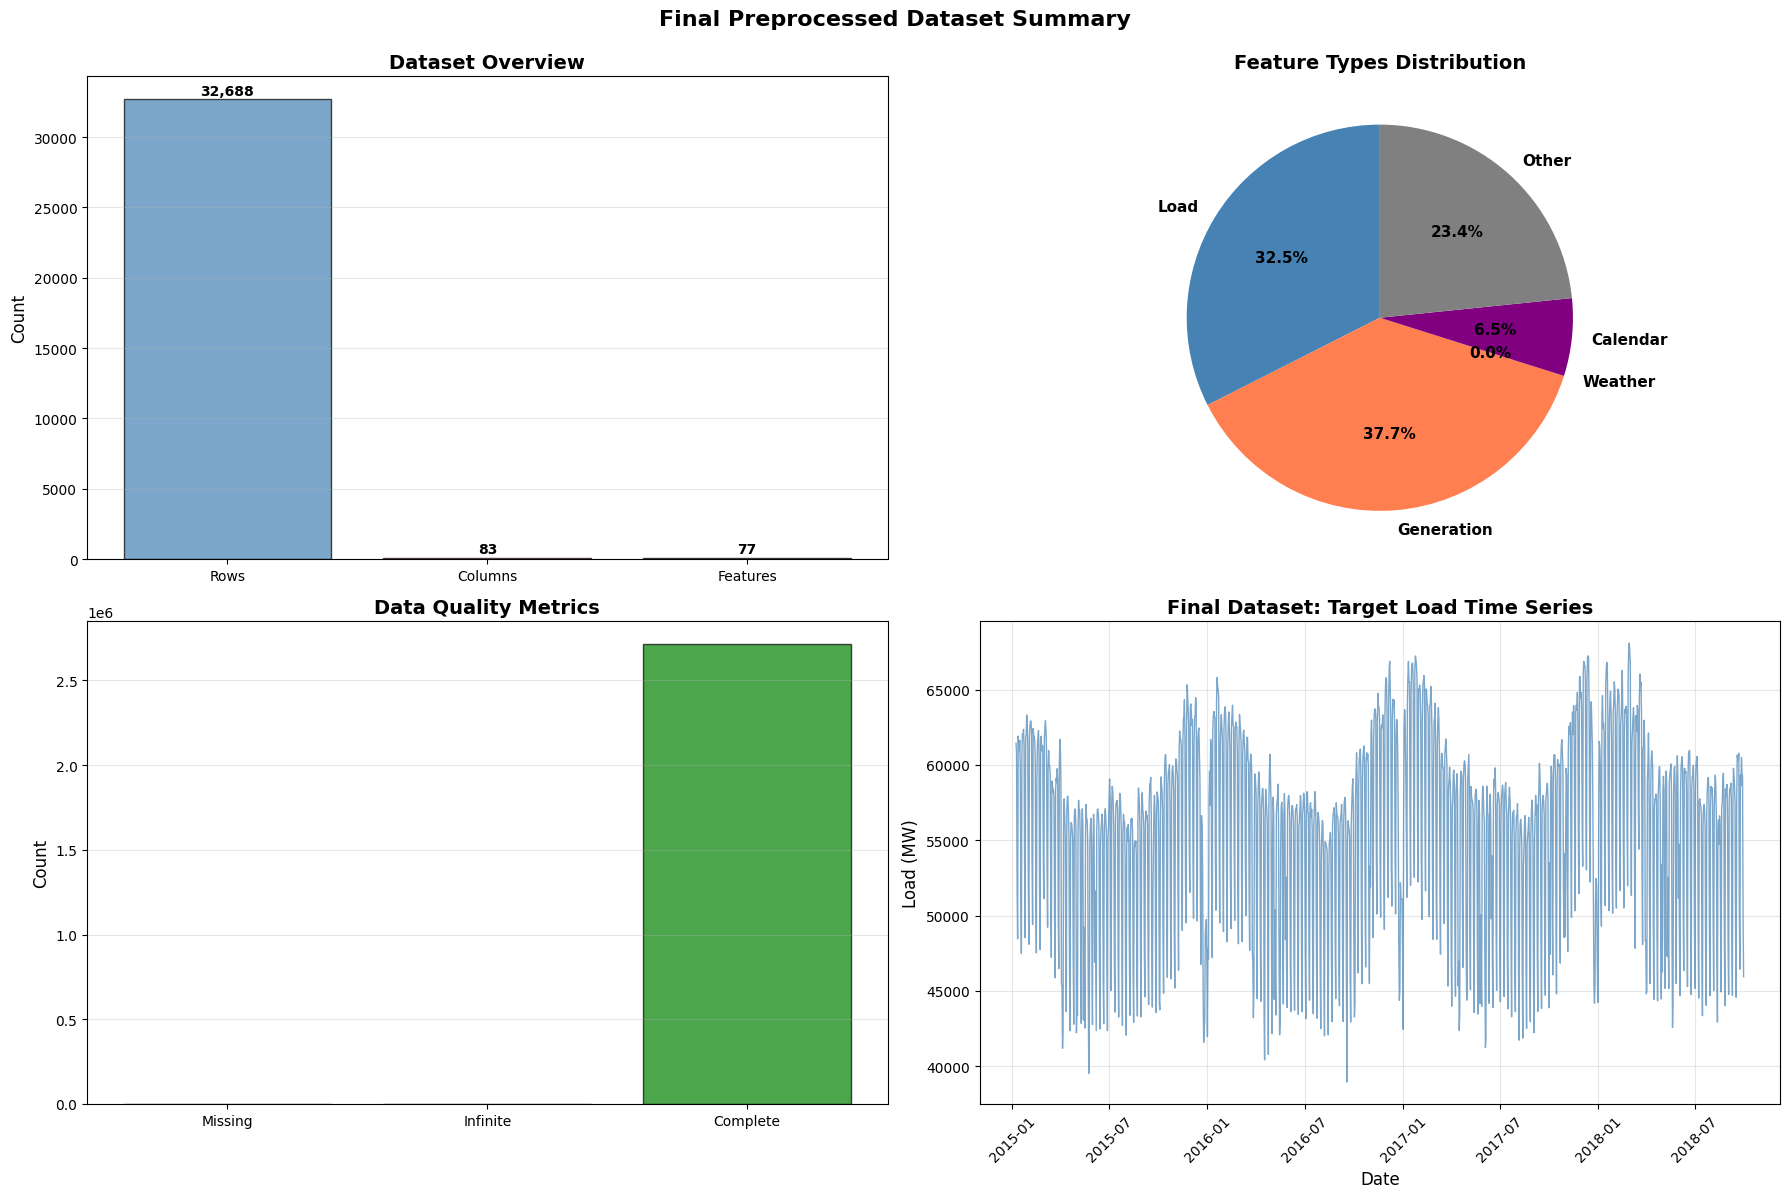


✓ Final dataset summary visualization complete
  Dataset shape: (32688, 83)
  Date range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
  Missing values: 0
  Infinite values: 0


In [ ]:
# Final Dataset Summary Visualization
print("="*80)
print("FINAL DATASET SUMMARY VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Dataset overview
ax1 = axes[0, 0]
summary_data = {
    'Rows': len(df),
    'Columns': len(df.columns),
    'Features': len(df.select_dtypes(include=[np.number]).columns)
}
ax1.bar(summary_data.keys(), summary_data.values(), color=['steelblue', 'coral', 'green'], alpha=0.7, edgecolor='black')
ax1.set_title('Dataset Overview', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for k, v in summary_data.items():
    ax1.text(k, v + max(summary_data.values())*0.01, f'{v:,}', ha='center', fontweight='bold')

# 2. Feature types distribution
ax2 = axes[0, 1]
numeric_cols = df.select_dtypes(include=[np.number]).columns
load_cols = [c for c in numeric_cols if 'load' in c.lower()]
gen_cols = [c for c in numeric_cols if 'generation' in c.lower()]
weather_cols = [c for c in numeric_cols if any(x in c for x in ['temperature', 'wind_speed', 'humidity', 'precipitation', 'cloud_cover', 'solar_radiation', 'air_density'])]
calendar_cols = [c for c in df.columns if c in ['hour', 'day_of_week', 'month', 'quarter', 'year']]
other_cols = len(numeric_cols) - len(load_cols) - len(gen_cols) - len(weather_cols) - len(calendar_cols)

feature_types = ['Load', 'Generation', 'Weather', 'Calendar', 'Other']
feature_counts = [len(load_cols), len(gen_cols), len(weather_cols), len(calendar_cols), other_cols]
colors = ['steelblue', 'coral', 'green', 'purple', 'gray']
ax2.pie(feature_counts, labels=feature_types, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Feature Types Distribution', fontsize=14, fontweight='bold')

# 3. Data quality metrics
ax3 = axes[1, 0]
missing_total = df.isnull().sum().sum()
infinite_total = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
quality_metrics = {
    'Missing': missing_total,
    'Infinite': infinite_total,
    'Complete': len(df) * len(df.columns) - missing_total - infinite_total
}
colors_qual = ['red' if k == 'Missing' else 'orange' if k == 'Infinite' else 'green' for k in quality_metrics.keys()]
ax3.bar(quality_metrics.keys(), quality_metrics.values(), color=colors_qual, alpha=0.7, edgecolor='black')
ax3.set_title('Data Quality Metrics', fontsize=14, fontweight='bold')
ax3.set_ylabel('Count', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Time series coverage
ax4 = axes[1, 1]
if 'target_load' in df.columns:
    sample_ts = df['target_load'].resample('D').mean()
    ax4.plot(sample_ts.index, sample_ts.values, linewidth=1, alpha=0.7, color='steelblue')
    ax4.set_title('Final Dataset: Target Load Time Series', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Load (MW)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
else:
    ax4.text(0.5, 0.5, 'Target load not available', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.axis('off')

plt.suptitle('Final Preprocessed Dataset Summary', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✓ Final dataset summary visualization complete")
print(f"  Dataset shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Missing values: {missing_total:,}")
print(f"  Infinite values: {infinite_total:,}")
print("="*80)


---

## Step 20: Save Processed Data and Generate Report

Save the processed dataset and generate a comprehensive preprocessing report.


In [ ]:

# Create output directory
output_dir = f'processed_data_{RESOLUTION}'
Path(output_dir).mkdir(exist_ok=True)

# Save processed data
output_path = f'{output_dir}/processed_data_{RESOLUTION}.csv'
df.to_csv(output_path)
print(f"\nProcessed data saved to: {output_path}")

# Generate comprehensive report
report = {
    'resolution': RESOLUTION,
    'target_country': target_country,
    'target_variable': 'target_load',
    'initial': initial_stats,
    'final_dataset': {
        'shape': df.shape,
        'missing_values': int(df.isnull().sum().sum()),
        'infinite_values': int(np.isinf(df.select_dtypes(include=[np.number])).sum().sum()),
        'date_range': {
            'start': str(df.index.min()),
            'end': str(df.index.max())
        },
        'total_features': len(df.columns),
        'total_samples': len(df)
    },
    'preprocessing_steps': {
        'missing_values_imputed': total_imputed,
        'outliers_treated': treated_count,
        'calendar_features': len(calendar_feature_cols),
        'lagged_features': len(lagged_features),
        'weather_features': len(weather_features)
    },
    'summary_statistics': {
        'target_load': {
            'mean': float(df['target_load'].mean()),
            'std': float(df['target_load'].std()),
            'min': float(df['target_load'].min()),
            'max': float(df['target_load'].max()),
            'median': float(df['target_load'].median())
        }
    }
}

# Save report
report_path = f'{output_dir}/preprocessing_report_{RESOLUTION}.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"Preprocessing report saved to: {report_path}")

print(f"\n{'='*80}")
print("PREPROCESSING COMPLETE!")
print(f"{'='*80}")
print(f"\nSummary:")
print(f"Resolution: {RESOLUTION}")
print(f"Initial shape: {initial_stats['shape']}")
print(f"Final shape: {df.shape}")
print(f"Features created: {len(df.columns)}")
print(f"Missing values imputed: {total_imputed:,}")
print(f"Outliers treated: {treated_count:,}")
print(f"Output file: {output_path}")
print(f"Report file: {report_path}")



Processed data saved to: processed_data_60min/processed_data_60min.csv
Preprocessing report saved to: processed_data_60min/preprocessing_report_60min.json

PREPROCESSING COMPLETE!

Summary:
Resolution: 60min
Initial shape: (32856, 299)
Final shape: (32688, 83)
Features created: 83
Missing values imputed: 164,624
Outliers treated: 835
Output file: processed_data_60min/processed_data_60min.csv
Report file: processed_data_60min/preprocessing_report_60min.json
